The cell below contains packages that might need to be installed if not done so already. Uncomment for a one time installation.

In [8]:
#!pip install seaborn --upgrade
#!pip install --upgrade pip
#!pip install seaborn==0.9.0
!pip install tabulate
!pip install plotly
#!pip install sklearn

Imports.

In [9]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set()
plt.style.use('fivethirtyeight')

import zipfile
import os # Used to interact with the file system

import re
from copy import deepcopy
from tabulate import tabulate

import plotly.express as px

import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model as lm
from sklearn.feature_extraction import DictVectorizer

from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

# Note: If you're having problems with the 3d scatter plots, uncomment the two lines below, and you should see a version that 
#      number that is at least 4.1.1.
# import plotly
# plotly.__version__

# Chess : Data Analysis & Visualization

### Data provided by Lichess API tool

<br>

Hello! This notebook is designed to help you gain some insight into your chess play, whether you are a new or seasoned player. Using your LiChess account, you will be able to get many visualizations and tables that provide information and comparisons with other users on win/loss, opening play, clock times and engine evaluations.

That being said, there is quite a bit of work that needs to be done in order to use this notebook, mainly corresponding to the first section of the notebook, Setup. That section will walk you through all of the work you need to do in order to get everything running, but to summarize, you will need to download your games off of https://lichess.org/api and use the replace feature in the case of errors when parsing the file. 

The first section of the notebook converts your PGN file into a CSV file (table); once you have the CSV file, you do not need to run the first section until you get new data (or equivalently, a new PGN file). 

The second section must be run every time the notebook is restarted. It reads in the CSV file and sets a lot of other important variables that will be used later on.

The analysis begins at section 3; while each section has its own separate topic/focus, sections 3 and 4 may be needed to run the other sections later on. The sections can be categorized as such:

- Essential: Sections 3 and 4. Covers the most fundamental statistics for a user and their opening repertoire, the latter being the most important component of this notebook in my opinion.
<br>

- Interesting: Sections 6 and 7. These deal with engine evaluations and clock times, and whil they can be argued to be equally as useful as sections 3 and 4, the PGN files do not guarantee that engine evaluations or clock times will be recorded for all games. In fact, it's been reported that only 6% of games come with an engine evaluation (To get an engine evaluation in the PGN file, you need to have clicked "Request a Computer Analysis" for that game on LiChess at some point).
<br>

- For fun: Sections 5, 8 and 9. There is no analysis in these sections, but perhaps you can still take away something useful from them. They are interesting tools that each have their purpose outside of analysis, and hopefully you will have fun playing around with them as well. 

<br>
<br>
<br>

## Table of Contents
------------------------------------

### 1. <a href='#setup'>Setup</a>
------------------------------------
### 2. <a href='#csv'>CSV loading</a>
### 3. <a href='#bus'>Basic User Stats</a>
### 4. <a href='#open'>Openings</a>
### 5. <a href='#pot'>Personal Opening Tree</a>
### 6. <a href='#stock'>Engine Evaluation</a>
### 7. <a href='#time'>Time Analysis</a>
### 8. <a href='#szn'>Seasons</a>
### 9. <a href='#log'>Win Predictor</a>

<a id='setup'></a>
<br>
<br>

## 1. Setup

### Read here first! 

Setup takes in a PGN file generated from https://lichess.org/api, and is meant to analyze the games of one user. So anyone using this should download their PGN by going to Games -> Export games of a user. 

There are many parameters for download; it is important that you use the rated tag! Using casual games will not work with the current setup to build a CSV. Additionally, only standard games are allowed! No variants like bughouse, chess960 or antichess. The setup will error if it detects a non-standard game, and this can be avoided by setting the perfType to include any combination of blitz, bullet, classical or rapid.

The following tags should also be set to true to get the most out of the analysis: clocks, evals (make sure to analyze your games on Lichess!), opening.  

TLDR; you may also just use the link provided below, after changing USERNAME to your LiChess username:

https://lichess.org/api/games/user/USERNAME?clocks=true&evals=true&opening=true&rated=true&perfType=classical,blitz,bullet,rapid




#### Input: PGN file
#### Output: Sorted CSV to create a data frame with the following columns:
    1. "Year", "Month", "Day"
    2. "Color"
    3. "Result"
    4. "Moves"
    4. "Opponent"
    5. "Opening", "Variation", "ECO", "ECO1", "ECO2"
    6. "Time", "Increment", "Event"
    7. "Rating", "OpponentRating", "RatingChange"
    8. "WhiteMoves", "BlackMoves"
    9. "WhiteRating", "BlackRating", "WhiteStockfish", "BlackStockfish"
    10. "WhiteSeconds", "BlackSeconds", "WhiteMinutes", "BlackMinutes", "WhiteTotalSeconds", "BlackTotalSeconds", "WhiteTotalMinutes", "BlackTotalMinutes"
    11. "Win", "Loss", "Draw"
    12. The columns not needed but kept just in case: "Site", "UTCDate", "UTCTime", "Termination"
    
#### Or, an alternate view:

['Year', 'Month', 'Day', 'Color', 'Result', 'Opponent', 'Opening', 'Variation', 
        'ECO', 'ECO1', 'ECO2', 'Time', 'Increment', 'Event', 
        'Rating', 'OpponentRating', 'RatingChange', 'WhiteMoves', 'BlackMoves', 'WhiteRating', 'BlackRating', 
       'WhiteStockfish', 'BlackStockfish', 'WhiteSeconds', 'BlackSeconds', 'WhiteMinutes', 'BlackMinutes', 
       'WhiteTotalSeconds', 'BlackTotalSeconds', 'WhiteTotalMinutes', 'BlackTotalMinutes', 'Site', 'UTCDate', 'UTCTime',
       'Termination']

#### Once you have done that, you will have a PGN file downloaded on your computer. Move that to the same folder as this ipynb file, and type in the name of the file without .PGN in the cell below.

Ex. if the file was named "Sicilian.pgn", then set the variable FILE_NAME to "Sicilian".

In [10]:
FILE_NAME = "e9"

#### Also input your Lichess username. Capitalization matters.

Ex. if your username is "FriedLiver", then set the variable USERNAME to "FriedLiver".

In [11]:
USERNAME = "electric_k9"

#### To build the CSV from the given format, many adjustments were needed:
##### 1. parse_pgn(): Transform the first 17/18 row entries into columns with regex
    1. Entry 0, check rated; else error
    2. Entries 1-16
    3. Check that all are standard; else error
##### 2. parse_notation(): 18th row, game notation
    1. Game moves
    2. Engine Rating
    3. Move times (part I)
##### 3. time_fn(): Handling move time increment
    1. Time Control -> time and increment columns
    2. Move times (part II)
##### 4. format_df(): Formatting columns
    1. "Player view" - Player Color, Opponent, Result, Elo, Rating Diff
    2. Date/time related columns
    3. Opening - splitting ECO/opening/variation
    4. Reorder all columns

**Common Errors**:

Due to the nature of the PGN files downloaded from LiChess API, many errors are simply unavoidable without significantly more code during parsing, and so they must be dealt with through the PGN file. To deal with these errors, I suggest having a program like Notepad++. The chance of an error is roughly ~70% for games that have over 1000 games, based on 20 accounts tested.

The majority of errors fall within the first 2 categories.


1. You played a player with a FIDE title before. The PGN contains titles of players, like [WhiteTitle "FM"]. There are too many titles as possibilities, including LM, NM, CM, FM, IM, GM, BOT, and all the arena and women's titles as well. Sometimes the PGN also includes [FEN ...] and [Setup ...]. These need to be removed manually in a program like Notepad++, using find and replace. In Notepad++, you can enable "regular expression" under search mode and enter both of the regex expressions in the cell below (one at a time) into the "find what" field, and leave "replace with" empty. Replace and they should all be gone.
<br>
<br>
2. If setup is still failing, it's most likely going to be that a game doesn't track rating difference in the PGN, so [WhiteRatingDiff ...] and [BlackRatingDiff ...] are missing. A regex is provided below to find games where this occurs. Manually remove the game or fix it in Notepad++. 
<br>
<br>
3. There are events like "Italian Game Superblitz Arena" that have a different format on the PGN, and they all need to be removed manually as well if they error. Not all of these error, events like "Hourly/Weekly SuperBlitz Arena" are fine.
<br>
<br>
4. The variant is not "Standard" even after filtering by events, and very common is "From Position". All the games with this need to be removed.

In [12]:
# Error #1: use the regex below for replace
'''

\[[^\s]*Title\s"[^"]*"]\n


\[FEN[^\]]*\]\n\[SetUp[^\]]*\]\n


'''



# Error #2:
'''
BlackElo[^\]]*\]\n\[Variant
'''

'\nBlackElo[^\\]]*\\]\n\\[Variant\n'

#### Run the cells below to generate a CSV. Drag the CSV into the folder with this ipynb file (if it isn't already), and proceed to later steps.

<br>

**Important**: once you have the CSV, you do not need to run Setup on any of these games again. If you have additional games to add in the future, you can download those separately by specifying a time to start from on the API: "since" or "until", which represents the unix epoch time in milliseconds: https://www.unixtimestamp.com/index.php. Or, you can just run all your games on this again and replace the new CSV with your old one. If you already had an existing CSV and you ran section 1 again, the new generated CSV file will replace the old one if their names are the same.

<br>

And if you error, refer to the error guide above and then run the cells below again.
<br>
<br>


In [13]:

def parse_pgn():

    pgn_input = pd.read_table(FILE_NAME + '.pgn', names=['r'])



    ###### 18 entries per game

    ### Column Names
    names = [
        "Event", #0
        "Site",
        "Date",
        "White",
        "Black",
        "Result", #5
        "UTCDate",
        "UTCTime",
        "WhiteElo",
        "BlackElo",
        "WhiteRatingDiff", #10
        "BlackRatingDiff",
        "Variant",
        "TimeControl",
        "ECO",
        "Opening", #15
        "Termination"
    ]



    ### Entry 0: special regex
    df = (pgn_input.iloc[0::18].reset_index()["r"]).str.extract("\[[a-zA-Z]*\s\"[^\"\s]*\s([^\"\s]*)").rename(columns={
        0:"Event"
    })


    # check for error
    rated = (pgn_input.iloc[0::18].reset_index()["r"]).str.findall("\[[a-zA-Z]*\s\"([^\"\s]*)")



    ### Entries 1-16: common regex
    for i in np.arange(1, 17):
        if (i != 2):
            fixed = (pgn_input.iloc[i::18].reset_index()["r"]).str.extract("\[[a-zA-Z]*\s\"([^\"]*)")
            df[names[i]] = fixed   


    # check for error
    for i in np.arange(len(df["Variant"])):
        if (df["Variant"][i] != "Standard"):
            for j in np.arange(len(df)):
                print(df.loc[j])
            print(df["Variant"])
            print(df.loc[i])
            raise ValueError('All games must be Standard variant.')

    del df["Variant"]


    ### Entry 17: game notation regex

    ## Game moves

    df["WhiteMoves"] = (pgn_input.iloc[17::18].reset_index()["r"]).str.findall("[0-9]\.\s([^\s]*)")
    df["BlackMoves"] = (pgn_input.iloc[17::18].reset_index()["r"]).str.findall(
        "[0-9]+\.\s[^\s]*\s([a-zA-Z][^\s]*) | }\s([a-zA-Z][^\s]*) | }\s[0-9]*\.\.\.\s([a-zA-Z][^\s]*)")

    for i in np.arange(len(df["BlackMoves"])):
        index = 0
        for j in np.arange(len(df["BlackMoves"][i])):
            if (j == 0):
                if (df["BlackMoves"][i][j][1] != ''):
                    index = 1
                elif (df["BlackMoves"][i][j][2] != ''):
                    index = 2
            df["BlackMoves"][i][j] = df["BlackMoves"][i][j][index]

    moves = []
    for i in np.arange(len(df["WhiteMoves"])):
        moves.append(len(df["WhiteMoves"][i]))
        
    df["Moves"] = moves

    ## Engine rating

    whiteStockfish = (pgn_input.iloc[17::18].reset_index()["r"]).str.findall("[0-9]+\.\s[^\s]*\s{\s\[%eval\s([^\]]*)")
    blackStockfish = (pgn_input.iloc[17::18].reset_index()["r"]).str.findall("[0-9]+\.\.\.\s[^\s]*\s{\s\[%eval\s([^\]]*)")

    ratings = (pgn_input.iloc[17::18].reset_index()["r"]).str.findall("%eval\s([^\]]*)")

    # converting str to int

    for i in np.arange(len(whiteStockfish)):
        for j in np.arange(len(whiteStockfish[i])):
            if ('#-' in whiteStockfish[i][j]):
                whiteStockfish[i][j] = -15
            elif ('#' in whiteStockfish[i][j]) or (float(whiteStockfish[i][j]) > 15):
                whiteStockfish[i][j] = 15
            elif (float(whiteStockfish[i][j]) < -15):
                whiteStockfish[i][j] = -15
            else:
                whiteStockfish[i][j] = float(whiteStockfish[i][j])

    for i in np.arange(len(blackStockfish)):
        for j in np.arange(len(blackStockfish[i])):
            if ('#-' in blackStockfish[i][j]):
                blackStockfish[i][j] = -15
            elif ('#' in blackStockfish[i][j]) or (float(blackStockfish[i][j]) > 15):
                blackStockfish[i][j] = 15
            elif (float(blackStockfish[i][j]) < -15):
                blackStockfish[i][j] = -15
            else:
                blackStockfish[i][j] = float(blackStockfish[i][j])


    for i in np.arange(len(ratings)):
        for j in np.arange(len(ratings[i])):
            if ('#-' in ratings[i][j]):
                ratings[i][j] = -15
            elif ('#' in ratings[i][j]) or (float(ratings[i][j]) > 15):
                ratings[i][j] = 15
            elif (float(ratings[i][j]) < -15):
                ratings[i][j] = -15
            else:
                ratings[i][j] = float(ratings[i][j])


    # Deep copying rating from stockfish 
    whiteRating = []
    blackRating = []
    
    for i in np.arange(len(whiteStockfish)):
        whiteRating.append(deepcopy(whiteStockfish[i]))

    for i in np.arange(len(blackStockfish)):
        blackRating.append(deepcopy(blackStockfish[i]))


    # Calculating rating increase/decrease for every move

    for i in np.arange(len(ratings)):
        for j in np.arange(len(ratings[i])):
            if ((j != 0) & (j % 2 == 0)):
                whiteRating[i][int(j / 2)] = ratings[i][j] - ratings[i][j - 1]
            elif (j % 2 == 1):
                blackRating[i][int(j / 2)] = ratings[i][j] - ratings[i][j - 1]

    df["WhiteRating"] = whiteRating
    df["BlackRating"] = blackRating

    df["WhiteStockfish"] = whiteStockfish
    df["BlackStockfish"] = blackStockfish



    ## Move times (highest runtime)
    # opted for full coverage with hours inclusion as well, although >99% not needed

    # this part realllyy wasn't fun
    whiteHours = (pgn_input.iloc[17::18].reset_index()["r"]).str.findall("[0-9]+\.\s[^%]*(?:%eval[^\[]*\[)*%clk\s([^:]*)")
    blackHours = (pgn_input.iloc[17::18].reset_index()["r"]).str.findall("(?:(?:})|(?:[0-9]+\.\.\.))\s[a-zA-Z][^%]*(?:%eval[^\[]*\[)*%clk\s([^:]*)")

    whiteMinutes = (pgn_input.iloc[17::18].reset_index()["r"]).str.findall("[0-9]+\.\s[^%]*(?:%eval[^\[]*\[)*%clk\s[^:]*:([^:]*)")
    blackMinutes = (pgn_input.iloc[17::18].reset_index()["r"]).str.findall("(?:(?:})|(?:[0-9]+\.\.\.))\s[a-zA-Z][^%]*(?:%eval[^\[]*\[)*%clk\s[^:]*:([^:]*)")

    whiteSeconds = (pgn_input.iloc[17::18].reset_index()["r"]).str.findall("[0-9]+\.\s[^%]*(?:%eval[^\[]*\[)*%clk\s[^:]*:[^:]*:([^\]]*)")
    blackSeconds = (pgn_input.iloc[17::18].reset_index()["r"]).str.findall("(?:(?:})|(?:[0-9]+\.\.\.))\s[a-zA-Z][^%]*(?:%eval[^\[]*\[)*%clk\s[^:]*:[^:]*:([^\]]*)")

    assert len(whiteHours) == len(whiteMinutes) == len(whiteSeconds) == len(blackHours) == len(blackMinutes) == len(blackSeconds)


    # converting str to int

    for i in np.arange(len(whiteMinutes)):
        whiteHours[i] = list(map(int, whiteHours[i]))
        blackHours[i] = list(map(int, blackHours[i]))

        whiteMinutes[i] = list(map(int, whiteMinutes[i]))
        blackMinutes[i] = list(map(int, blackMinutes[i]))

        whiteSeconds[i] = list(map(int, whiteSeconds[i]))
        blackSeconds[i] = list(map(int, blackSeconds[i]))


    # convert to array to multiply minutes/hours with constants, since a list * c only lengthens the list size by c in python.
    # benchmark shows that mapping and list comprehensions are slower than conversion to array for almost all N

    whiteTotalSeconds = whiteHours.copy(deep=True)
    whiteTotalMinutes = whiteHours.copy(deep=True)

    blackTotalMinutes = blackHours.copy(deep=True)
    blackTotalSeconds = blackHours.copy(deep=True)

    for i in np.arange(len(whiteMinutes)):
        tmpW = np.array(whiteHours[i]) * 3600 + np.array(whiteMinutes[i]) * 60 + np.array(whiteSeconds[i])
        whiteTotalSeconds[i] = tmpW.tolist()
        whiteTotalMinutes[i] = (tmpW / 60).tolist()

        tmpB = np.array(blackHours[i]) * 3600 + np.array(blackMinutes[i]) * 60 + np.array(blackSeconds[i])
        blackTotalSeconds[i] = tmpB.tolist()
        blackTotalMinutes[i] = (tmpB / 60).tolist()

    df["WhiteTotalSeconds"] = whiteTotalSeconds
    df["BlackTotalSeconds"] = blackTotalSeconds

    df["WhiteTotalMinutes"] = whiteTotalMinutes
    df["BlackTotalMinutes"] = blackTotalMinutes
    

    ### Time Control

    # time (first part)
    time = df["TimeControl"].str.findall("([^\+]*)\+")
    for i in np.arange(len(time)):
        time[i] = (list(map(int, time[i])))[0]

    #increment (second part)
    increment = df["TimeControl"].str.findall("\+([^\+]*)")
    for i in np.arange(len(increment)):
        increment[i] = (list(map(int, increment[i])))[0]

    df["Time"] = time
    df["Increment"] = increment
    del df["TimeControl"]



    ## Move Times (part II)
    # Deep copying times from TotalSeconds/TotalMinutes 

    for i in np.arange(len(whiteTotalSeconds)):
        whiteSeconds[i] = deepcopy(whiteTotalSeconds[i])
        whiteMinutes[i] = deepcopy(whiteTotalMinutes[i])

    for i in np.arange(len(blackTotalSeconds)):
        blackSeconds[i] = deepcopy(blackTotalSeconds[i])
        blackMinutes[i] = deepcopy(blackTotalMinutes[i])


    # Calculating time spent for every move

    for i in np.arange(len(whiteTotalSeconds)):
        for j in np.arange(len(whiteTotalSeconds[i])):
            if (j == 0):
                whiteSeconds[i][j] = 0
                whiteMinutes[i][j] = 0
            else:
                whiteSeconds[i][j] = whiteTotalSeconds[i][j - 1] - whiteTotalSeconds[i][j] + increment[i]
                whiteMinutes[i][j] = whiteSeconds[i][j] / 60

    for i in np.arange(len(blackTotalSeconds)):
        for j in np.arange(len(blackTotalSeconds[i])):
            if (j == 0):
                blackSeconds[i][j] = 0
                blackMinutes[i][j] = 0
            else:
                blackSeconds[i][j] = blackTotalSeconds[i][j - 1] - blackTotalSeconds[i][j] + increment[i]
                blackMinutes[i][j] = blackSeconds[i][j] / 60

    df["BlackSeconds"] = blackSeconds
    df["WhiteSeconds"] = whiteSeconds

    df["BlackMinutes"] = blackMinutes
    df["WhiteMinutes"] = whiteMinutes




    ### Switching to player view

    ## Player Color

    df["Color"] = "White"
    df.loc[df["Black"] == USERNAME, "Color"] = "Black"


    ## Opponent

    df["Opponent"] = df["White"]
    df.loc[df["Black"] != USERNAME, "Opponent"] = df["Black"]
    del df["White"]
    del df["Black"]


    ## Result

    # regex and loop for first part of result input
    result = df["Result"].str.findall("([^-]*)-")

    for i in np.arange(len(result)):
        if (result[i][0] == '1/2'):
            result[i] = 0.5
        else:
            result[i] = (list(map(int, result[i])))[0]

    df["Result"] = result

    # flip result if player is black
    df.loc[df["Color"] == "Black", "Result"] = 1 - df["Result"]


    # add win, loss, draw
    df["Win"] = (df["Result"] == 1.0).astype(int)
    df["Loss"] = (df["Result"] == 0.0).astype(int)
    df["Draw"] = (df["Result"] == 0.5).astype(int)

    ## Elo

    # Self Elo
    df["Rating"] = df["WhiteElo"]
    df.loc[df["Color"] == "Black", "Rating"] = df["BlackElo"]

    # Opponent Elo
    df["OpponentRating"] = df["WhiteElo"]
    df.loc[df["Color"] == "White", "OpponentRating"] = df["BlackElo"]

    del df["WhiteElo"]
    del df["BlackElo"]


    ## Rating Diff

    # Self Elo
    df["RatingChange"] = df["WhiteRatingDiff"]
    df.loc[df["Color"] == "Black", "RatingChange"] = df["BlackRatingDiff"]

    del df["WhiteRatingDiff"]
    del df["BlackRatingDiff"]


    ## Date/Time

    # year
    year = df["UTCDate"].str.findall("([^\.]*)\.")

    for i in np.arange(len(year)):
        year[i] = (list(map(int, year[i])))[0]

    df["Year"] = year

    # month
    month = df["UTCDate"].str.findall("\.([^\.]*)\.")

    for i in np.arange(len(month)):
        month[i] = (list(map(int, month[i])))[0]

    df["Month"] = month
    
    # day - has its specific purpose in a time graph
    day = df["UTCDate"].str.findall("\.[^\.]*\.([^\"]*)")

    for i in np.arange(len(day)):
        day[i] = (list(map(int, day[i])))[0]

    df["Day"] = day

    ## Opening

    # ECO code split
    letter = df["ECO"].str.findall("([A-Z])")
    number = df["ECO"].str.findall("[A-Z]([0-9]*)")

    for i in np.arange(len(letter)):
        if (letter[i] != []):
            letter[i] = (list(map(str, letter[i])))[0]
            number[i] = (list(map(int, number[i])))[0]
        else:
            letter[i] = ""
            number[i] = 0

    df["ECO1"] = letter
    df["ECO2"] = number

    # Variation
    variation = df["Opening"].str.findall(":\s(.*)")
    for i in np.arange(len(variation)):
        if (variation[i] != []):
            variation[i] = variation[i][0]
        else:
            variation[i] = "Main Line"

    df["Variation"] = variation


    # Opening
    opening = df["Opening"]
    for i in np.arange(len(variation)):
        opening[i] = re.search("([^:]*)", df["Opening"][i]).group()

    df["Opening"] = opening

    # Reordering
    cols = ['Year', 'Month', 'Day', 'Color', 'Result', 'Moves', 'Opponent', 'Opening', 'Variation', 
            'ECO', 'ECO1', 'ECO2', 'Time', 'Increment', 'Event', 
            'Rating', 'OpponentRating', 'RatingChange', 'WhiteMoves', 'BlackMoves', 'WhiteRating', 'BlackRating', 
           'WhiteStockfish', 'BlackStockfish', 'WhiteSeconds', 'BlackSeconds', 'WhiteMinutes', 'BlackMinutes', 
           'WhiteTotalSeconds', 'BlackTotalSeconds', 'WhiteTotalMinutes', 'BlackTotalMinutes', 
            'Win', 'Loss', 'Draw', 'Site', 'UTCDate', 'UTCTime',
           'Termination']
    df = df.reindex(columns = cols)
    
    return df
    

#### Run Setup.

In [14]:
dp = parse_pgn()

#### (Optional): view the table (and check for potential errors). 

In [15]:
dp

Year Month Day  Color Result  Moves              Opponent  \
0   2021     3  14  Black      1     16           carloslayun   
1   2021     3   8  White      1     23            piffolopuf   
2   2021     3   6  White      1     40             grazia121   
3   2021     3   4  Black      1     18             Puckster2   
4   2021     3   3  White      1     25                katoks   
5   2021     3   3  Black      0     32              avatar71   
6   2021     3   1  Black      0     20                asuvor   
7   2021     3   1  White      1     19     MiguelRojoImpar23   
8   2021     2  26  Black      1     17                Firsin   
9   2021     2  25  White      1     13           fazan_admin   
10  2021     2  25  Black      1     17              SergVish   
11  2021     2  20  White      1     25             Zlatokosy   
12  2021     2  20  Black      1     42             JokerLiar   
13  2021     2  20  White      1     22           ecureuil_69   
14  2021     2  19  Black      1     38            domenico61   
15  2021     2  19  Black      0     38           PawnBlusher   
16  2021     2  18  Black      1     14            AlejandroM   
17  2021     2  16  White      1     19        mladendjuric55   
18  2021     1  25  Black      1     43               arcnaka   
19  2021     1  24  White    0.5     34      jackbauerpwrhour   
20  2021     1  17  White      1     29               Ceron68   
21  2021     1  17  White      0     47     Master_Don_Pundon   
22  2021     1  16  White      1     25          buongiorgio1   
23  2021     1  15  Black    0.5     46       Yousefaboelmagd   
24  2021     1  14  Black      1     37         RichardSchach   
25  2021     1  14  White      0      4           Hamdyamin28   
26  2021     1  14  Black      0     12                psxt12   
27  2021     1  14  White      0     12              whichful   
28  2021     1  14  Black      0     14               chemaqe   
29  2021     1  14  Black      1     21            Prof-jones   
30  2021     1  13  White    0.5     40               aconito   
31  2021     1  12  White      1     30                ITAKAR   
32  2021     1   9  Black      1     27       Hamzzza-Nailkin   
33  2021     1   9  White      1     29               Hikal23   
34  2021     1   8  Black      1     48             JORGEAPRA   
35  2021     1   4  White    0.5     17  anthony_abogado21PWD   
36  2021     1   4  Black      0     56        Runa1791Runoid   
37  2021     1   3  Black      1     24           Numisma9999   
38  2021     1   3  White      1     40         InBetweenWins   
39  2021     1   2  Black      1     33          anotheralias   
40  2021     1   2  White      0     23                 zypek   
41  2020    12  16  Black      1     45                Zaibee   
42  2020    12  16  White      1     35                Zaibee   
43  2020    12  15  Black      0     18        Keshawa_151059   
44  2020    12  14  White      1     41        Feuchtmacher69   
45  2020    12  14  Black      0     10             OtakuYA99   
46  2020    12  14  Black      0      7   Nikoloz_rtskhiladze   
47  2020    12  14  Black      0     11             OtakuYA99   
48  2020    12  14  Black      0     61               Obrecht   
49  2020    12  13  Black      1     39            Artem10let   
50  2020    12  13  Black      0     23                  no3h   

                  Opening                                          Variation  \
0       Caro-Kann Defense                                          Main Line   
1        King's Pawn Game                                Nimzowitsch Defense   
2             Vienna Game                                          Main Line   
3       Caro-Kann Defense                                          Main Line   
4          French Defense                  Advance Variation, Paulsen Attack   
5     East Indian Defense                                          Main Line   
6       Caro-Kann Defense                                 Two K

#### Download csv file (go to File->Open or the folder to see it, or through local files).

In [16]:
dp.to_csv(FILE_NAME + '.csv', index=False)

<a id='csv'></a>
<br>
<br>

## 2. CSV loading

Must be run before any analysis after this can be looked at. Set FILENAME to the name of the csv without ".csv".

**Remember to change USERNAME every time as well.**

Ex. if the file was named "Sicilian.csv", then set the variable FILENAME to "Sicilian".

<br>

In [17]:
# FIX THESE
FILENAME = "e9"
USERNAME = "electric_k9"

# --------------------------------------------------


df = pd.read_csv(FILENAME + ".csv", converters={'WhiteMoves': eval, 'BlackMoves': eval,
                                               'WhiteStockfish': eval, 'BlackStockfish': eval,
                                               'WhiteRating': eval, 'BlackRating': eval,
                                               "WhiteSeconds":eval, "BlackSeconds":eval, 
                                                "WhiteMinutes":eval, "BlackMinutes":eval,
                                                "WhiteTotalSeconds":eval, "BlackTotalSeconds":eval, 
                                                "WhiteTotalMinutes":eval, "BlackTotalMinutes":eval})

white = df[df["Color"] == "White"]
black = df[df["Color"] == "Black"]

bullet = df[df["Event"] == "Bullet"]
blitz = df[df["Event"] == "Blitz"]
rapid = df[df["Event"] == "Rapid"]
classical = df[df["Event"] == "Classical"]


class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    

def filter_df(df, col, name):
    return df[df[col] == name]

Optional: run below to view dataframe.

In [18]:
df

Year  Month  Day  Color  Result  Moves              Opponent  \
0   2021      3   14  Black     1.0     16           carloslayun   
1   2021      3    8  White     1.0     23            piffolopuf   
2   2021      3    6  White     1.0     40             grazia121   
3   2021      3    4  Black     1.0     18             Puckster2   
4   2021      3    3  White     1.0     25                katoks   
5   2021      3    3  Black     0.0     32              avatar71   
6   2021      3    1  Black     0.0     20                asuvor   
7   2021      3    1  White     1.0     19     MiguelRojoImpar23   
8   2021      2   26  Black     1.0     17                Firsin   
9   2021      2   25  White     1.0     13           fazan_admin   
10  2021      2   25  Black     1.0     17              SergVish   
11  2021      2   20  White     1.0     25             Zlatokosy   
12  2021      2   20  Black     1.0     42             JokerLiar   
13  2021      2   20  White     1.0     22           ecureuil_69   
14  2021      2   19  Black     1.0     38            domenico61   
15  2021      2   19  Black     0.0     38           PawnBlusher   
16  2021      2   18  Black     1.0     14            AlejandroM   
17  2021      2   16  White     1.0     19        mladendjuric55   
18  2021      1   25  Black     1.0     43               arcnaka   
19  2021      1   24  White     0.5     34      jackbauerpwrhour   
20  2021      1   17  White     1.0     29               Ceron68   
21  2021      1   17  White     0.0     47     Master_Don_Pundon   
22  2021      1   16  White     1.0     25          buongiorgio1   
23  2021      1   15  Black     0.5     46       Yousefaboelmagd   
24  2021      1   14  Black     1.0     37         RichardSchach   
25  2021      1   14  White     0.0      4           Hamdyamin28   
26  2021      1   14  Black     0.0     12                psxt12   
27  2021      1   14  White     0.0     12              whichful   
28  2021      1   14  Black     0.0     14               chemaqe   
29  2021      1   14  Black     1.0     21            Prof-jones   
30  2021      1   13  White     0.5     40               aconito   
31  2021      1   12  White     1.0     30                ITAKAR   
32  2021      1    9  Black     1.0     27       Hamzzza-Nailkin   
33  2021      1    9  White     1.0     29               Hikal23   
34  2021      1    8  Black     1.0     48             JORGEAPRA   
35  2021      1    4  White     0.5     17  anthony_abogado21PWD   
36  2021      1    4  Black     0.0     56        Runa1791Runoid   
37  2021      1    3  Black     1.0     24           Numisma9999   
38  2021      1    3  White     1.0     40         InBetweenWins   
39  2021      1    2  Black     1.0     33          anotheralias   
40  2021      1    2  White     0.0     23                 zypek   
41  2020     12   16  Black     1.0     45                Zaibee   
42  2020     12   16  White     1.0     35                Zaibee   
43  2020     12   15  Black     0.0     18        Keshawa_151059   
44  2020     12   14  White     1.0     41        Feuchtmacher69   
45  2020     12   14  Black     0.0     10             OtakuYA99   
46  2020     12   14  Black     0.0      7   Nikoloz_rtskhiladze   
47  2020     12   14  Black     0.0     11             OtakuYA99   
48  2020     12   14  Black     0.0     61               Obrecht   
49  2020     12   13  Black     1.0     39            Artem10let   
50  2020     12   13  Black     0.0     23                  no3h   

                  Opening                                          Variation  \
0       Caro-Kann Defense                                          Main Line   
1        King's Pawn Game                                Nimzowitsch Defense   
2             Vienna Game                                          Main Line   
3       Caro-Kann Defense                                          Main Line   
4          French Defense                  Advance Variation, Pauls

<a id='bus'></a>
<br>
<br>

## 3. Basic User Stats

<br>

Covers:

&emsp;**3.1**. A user's win/loss across all modes and for each specific game mode

&emsp;**3.2**. Rating Difference vs Rating Change

&emsp;**3.3.1**. User Rating by Date

&emsp;**3.3.2**. User Rating Over Time

&emsp;**3.4**. Performance against opponent rating

<br>

### 3.1&emsp;Win/Loss

<br>

**Goal**: See winrate overall and for each game mode (Blitz, etc.). Useful knowledge to have for later graphs.

<br>

In [19]:
def wl_helper(data, side):
    results = data["Result"].value_counts().to_dict()
    gp = len(data["Result"])
    w = results.get(1, 0)
    l = results.get(0, 0)
    d = results.get(0.5, 0)
    if (w + l + d == 0):
        ppg = 0
    else:
        ppg = (w + 0.5 * d) / (w + l + d)
    
    print(color.BLUE + side)
    print(color.RED + "GP:\t\t" + str(gp))
    print("Record:\t\t" + str(w) + "-" + str(l) + "-" + str(d))
    print("PPG:\t\t" + str(round(ppg, 3)))
    
def wl(data, event):
    
    print(color.GREEN + event)
    wl_helper(data, "Overall:")
    mean = np.mean(data["OpponentRating"])
    print("AVG ELO:\t" + str(round(mean, 3)))
    
    wl_helper(data[data["Color"] == "White"], "White:")
    wl_helper(data[data["Color"] == "Black"], "Black:")
    
    print(color.END)
    

In [20]:
wl(df, "Total")
for i in ["Bullet", "Blitz", "Rapid", "Classical"]:
    if len(df[df["Event"] == i] != 0):
        wl(df[df["Event"] == i], i)


Total
Overall:
GP:		51
Record:		31-16-4
PPG:		0.647
AVG ELO:	1638.314
White:
GP:		22
Record:		15-4-3
PPG:		0.75
Black:
GP:		29
Record:		16-12-1
PPG:		0.569

Rapid
Overall:
GP:		37
Record:		23-12-2
PPG:		0.649
AVG ELO:	1636.486
White:
GP:		16
Record:		11-4-1
PPG:		0.719
Black:
GP:		21
Record:		12-8-1
PPG:		0.595

Classical
Overall:
GP:		14
Record:		8-4-2
PPG:		0.643
AVG ELO:	1643.143
White:
GP:		6
Record:		4-0-2
PPG:		0.833
Black:
GP:		8
Record:		4-4-0
PPG:		0.5



<br>

### 3.2&emsp;Rating Difference vs Rating Change

<br>

**Goal**: This plot isn't intended to show how the rating changes based on the rating difference; rather, it shows how the player chooses their matchmaking. Do they tend to play only players rated much higher than them? Or lower? Provides justification for a low/high winrate from the cells above.

<br>

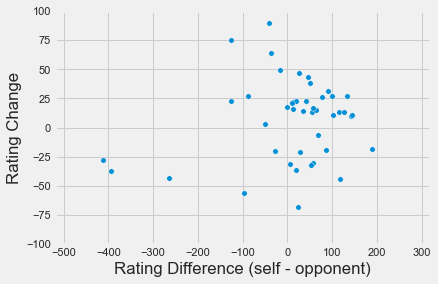

In [21]:
sns.scatterplot(data=df, x=df["Rating"] - df["OpponentRating"], y="RatingChange", s=30)
sns.set(rc={'figure.figsize':(12, 8)})

#plt.xlim(-600, 600)
plt.ylim(-100, 100)
#plt.legend()
plt.xlabel("Rating Difference (self - opponent)")
plt.ylabel("Rating Change")
#plt.title("")
plt.show()

<br>

### 3.3.1&emsp;User Rating By Date

<br>

**Goal**: View user's rating over time.

**Note**: X axis is not linearly proportional over time! Each x-tick represents a day where the user played at least one game, so this is more like user rating over games played.

**Potential error**: the below graph may not output the x-axis (date) in the correct order. If so, then run the cell below it, although it is a worse version of this below graph, in my opinion. The main difference is the below graph shows rating change over units of games played, while the other one shows rating change over units of time.

<br>

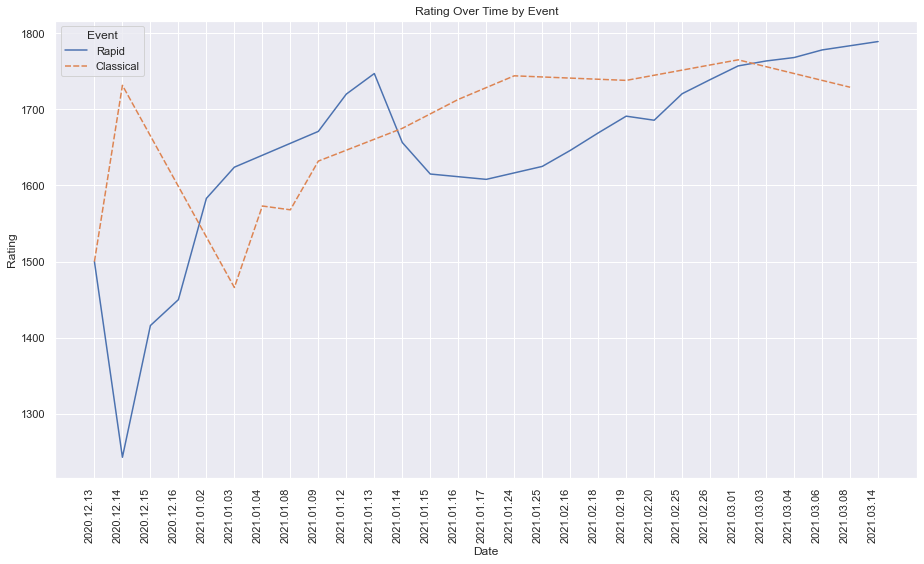

In [22]:
plt.figure(figsize=(13,8))
urot = df.copy(deep = True)
urot = urot.sort_values(by="UTCDate", ascending=True)
ax = sns.lineplot(data=urot, x="UTCDate", y="Rating", hue="Event", style="Event", ci=None, sort=False)
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

plt.xlabel("Date")
plt.ylabel("Rating")
plt.title("Rating Over Time by Event")
plt.tight_layout()
plt.show()

<br>

### 3.3.2&emsp;User Rating Over Time

<br>

**(Optional)**: If the cell above ran fine, then you don't really need to run this. This graphs based on time as a numeric value, so if you play many of your games in one short time period, then it'll appear as a big jump in rating on the graph (assuming there is a rating change). The x-axis also might not be printed properly, so if something like 20185 or 20180 shows up, interpret it as the middle of 2018 or the beginning of 2018.

**Goal**: Same as 3.3.1.

<br>

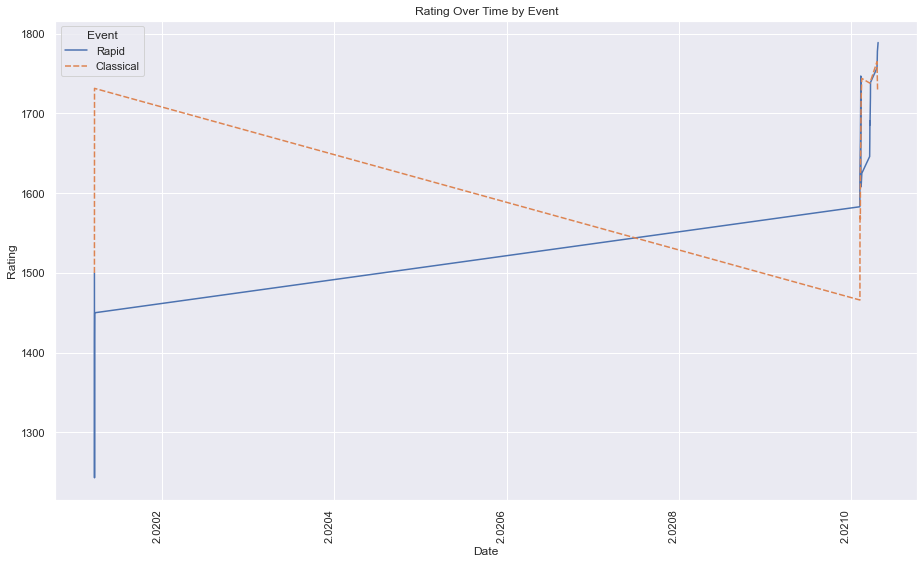

In [23]:
plt.figure(figsize=(13,8))
urot = df.copy(deep = True)
urot["fulldate"] = urot["Year"] * 10000 + urot["Month"] * 100 + urot["Day"]

ax = sns.lineplot(data=urot, x="fulldate", y="Rating", hue="Event", style="Event", ci=None, sort=True)
plt.draw()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

plt.xlabel("Date")
plt.ylabel("Rating")
plt.title("Rating Over Time by Event")
plt.tight_layout()
plt.show()


<br>

### 3.4&emsp;Performance against opponent rating

<br>

**Goal**: View user's winrate against a certain rating.

**Note**: The rating is represented as a range, since otherwise a winrate can't be calculated. There are two functions:

&emsp;perfELO_reg() : predicts winrate based on opponent rating.

&emsp;perf_ELO() : shows winrate based on opponent rating.

**Reminder**: From section 2, you can also use the following tables: bullet, blitz, rapid, classical, white, black. The first four represent games played only in that game mode, and the last two represent all games where you played as that side. This applies to all functions where you can provide an argument, but it is especially useful here because ratings are not equivalent across game modes!

<br>

Set how wide you want each rating group to be (the range).

In [24]:
N = 50

In [25]:
def perf_ELO_reg(df):
    plt.figure(figsize=(13,8))
    ax = sns.regplot(x=df["OpponentRating"], y=(df["Win"] + 0.5 * df["Draw"]) / (df["Win"] + df["Loss"] + df["Draw"]), 
                     x_bins=10)
    plt.draw()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

    plt.xlabel("Opponent ELO")
    plt.ylabel("PPG")
    plt.title("Performance against Opponent Rating")
    plt.tight_layout()
    plt.show()

In [26]:
def perf_ELO(df):
    mini = min(df["OpponentRating"])
    mini = round(mini / 50) * 50
    maxi = max(df["OpponentRating"])
    rating, score, count = [], [], []
    while (mini <= maxi):
        temp = df[(df["OpponentRating"] >= mini) & (df["OpponentRating"] < mini + N)]
        
        ppg = (np.sum(temp["Win"]) + 0.5 * np.sum(temp["Draw"])) / (
            np.sum(temp["Win"]) + np.sum(temp["Loss"]) + np.sum(temp["Draw"]))
        
        rating.append(str(mini) + "-" + str(mini + N))
        score.append(ppg)
        count.append(len(temp))
        
        mini += N
        
    plt.figure(figsize=(13,8))
    ax = sns.scatterplot(x=rating, y=score, size=count)
    plt.draw()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

    plt.xlabel("Opponent ELO")
    plt.ylabel("PPG")
    plt.title("Performance against Opponent Rating")
    plt.tight_layout()
    plt.show()
    


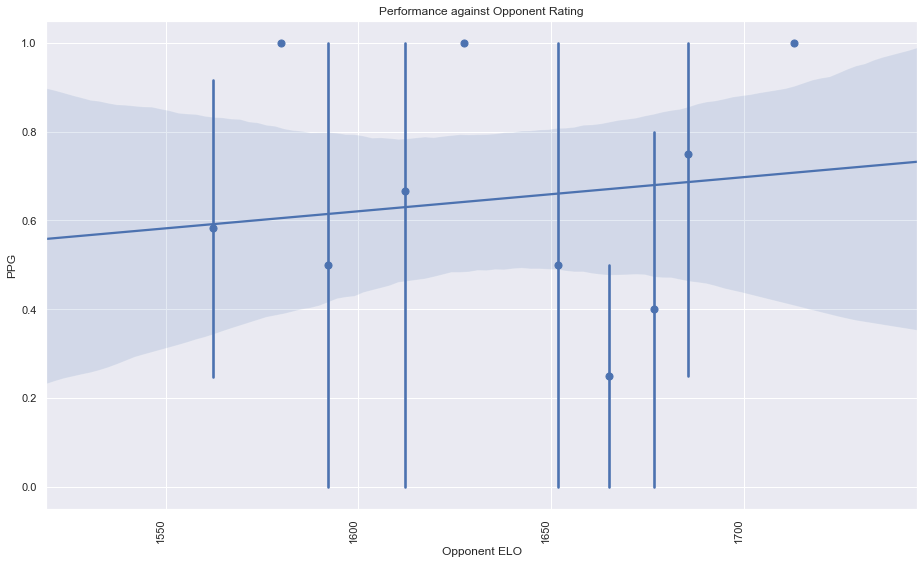

In [27]:
perf_ELO_reg(rapid)

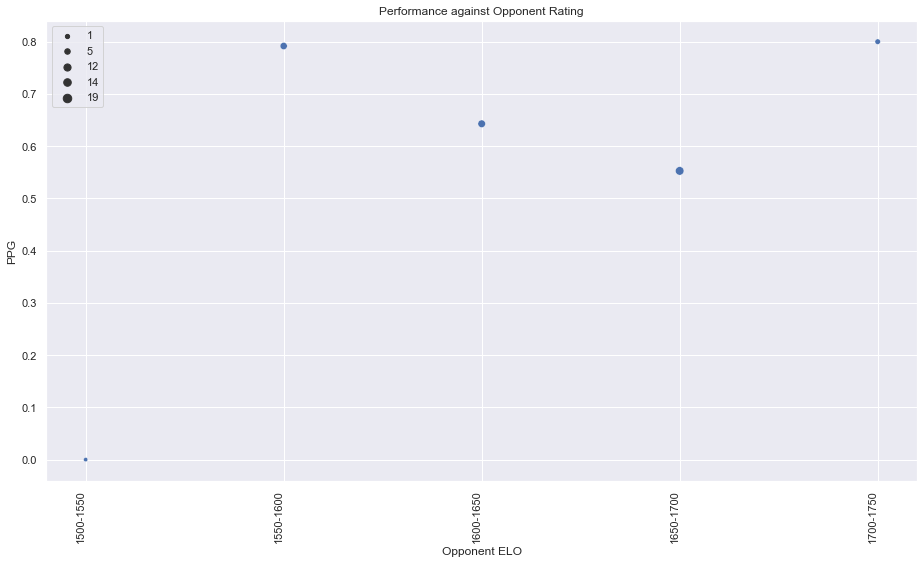

In [28]:
perf_ELO(df)

<a id='open'></a>
<br>
<br>

## 4. Openings

<br>

Covers:

&emsp;**4.1**. Openings played as White/Black

&emsp;**4.2**. Opening Variations


<br>

### 4.1&emsp;Openings played as White/Black

<br>

**Goal**: Provides a list of the openings a user has played as White or Black, and sorts them in order by openings played most often (GP = Games Played). Displays the top 20 openings for both sides. There are many columns that the user can draw information from. What to look for:

1. ***REL***: Shows the average points per game (PPG) scored using this opening minus the average points per game (PPG) of the user over all their openings on that side. Essentially, it represents how good the user plays that opening relative to all their other ones.


2. ***Rating Difference***: The part that may invalidate REL. Some players choose to play different openings against different ratings, typically playing more "drawish" or closed openings against better players and more aggressive or open openings against lower rated players. If you constantly lose with an opening because you're only playing it against higher rated players, that doesn't mean you're playing the opening worse compared to your other openings.


3. ***Rating Change (average per game) / Total Rating Gain***: The most important columns in my opinion. It combines both REL and rating difference to show how successful your opening is in your ELO/rating. Your expected rating gain against any opponent and any rating should be 0, because the rating system factors in how much better/worse an opponent is.


4. ***Moves***: Do games played under this opening tend to be long or short? If you are bad with fast games, you might want to consider picking openings that have a shorter number of moves on average.


5. ***W/L/D***: Probably the first thing you'll pick up on, anyway.

In [29]:
def opening_list(data):
    # groupby
    df = data[["Opening", "Win", "Loss", "Draw", "Moves", "Event",
              "Variation", "Rating", "OpponentRating", 
              "RatingChange"]].groupby("Opening").agg({"Win":np.sum, "Loss":np.sum,
                                                    "Draw":np.sum, "Moves":np.average,
                                                    "Event":lambda x: x.value_counts().index[0],
                                                    "Variation": lambda x: x.value_counts().index[0],
                                                    "Rating":np.average, "OpponentRating":np.average,
                                                    "RatingChange":np.average})
    
    # create count col
    df["GP"] = df["Win"] + df["Loss"] + df["Draw"]
    # sort by count
    df = df.sort_values(by = "GP", ascending = False)
    # total ELO gained
    df["Total Rating Gain"] = (df["GP"] * df["RatingChange"]).astype(int)
    # PPG (points per game)
    df["PPG"] = round((df["Win"] + 0.5 * df["Draw"]) / (df["Win"] + df["Loss"] + df["Draw"]), 3)
    # comparison to average PPG as black
    avg_ppg = round((np.sum(data["Win"]) + 0.5 * np.sum(data["Draw"])) / 
                    (np.sum(data["Win"]) + np.sum(data["Loss"]) + np.sum(data["Draw"])), 3)
    df["REL"] = df["PPG"] - avg_ppg 
    # round stuff
    df["Moves"] = round(df["Moves"], 1)
    df["Rating"] = round(df["Rating"]).astype(int)
    df["OpponentRating"] = round(df["OpponentRating"]).astype(int)
    df["Rating Difference"] = df["Rating"] - df["OpponentRating"]
    df["RatingChange"] = round(df["RatingChange"], 2)
    # reorder columns
    df = df[["GP", "Moves", "Win", "Loss", "Draw", "PPG", "REL", "Total Rating Gain", "Rating Difference",
            "RatingChange", "Variation", "Event"]]
    df = df.rename(columns={"Event":"Most played in", "Variation":"Most common variation"})
    
    return df

In [30]:
opening_list(white).head(20)

GP  Moves  Win  Loss  Draw    PPG    REL  \
Opening                                                          
Vienna Game            9   23.3    6     1     2  0.778  0.028   
French Defense         3   29.7    3     0     0  1.000  0.250   
Sicilian Defense       3   35.0    2     0     1  0.833  0.083   
Bishop's Opening       1   12.0    0     1     0  0.000 -0.750   
Caro-Kann Defense      1   13.0    1     0     0  1.000  0.250   
Italian Game           1   41.0    1     0     0  1.000  0.250   
King's Pawn Game       1   23.0    1     0     0  1.000  0.250   
Owen Defense           1   23.0    0     1     0  0.000 -0.750   
Rat Defense            1   29.0    1     0     0  1.000  0.250   
Scandinavian Defense   1   47.0    0     1     0  0.000 -0.750   

                      Total Rating Gain  Rating Difference  RatingChange  \
Opening                                                                    
Vienna Game                         112                 45         12.44   
French Defense                      195                -85         65.00   
Sicilian Defense                    130                 52         43.33   
Bishop's Opening                    -31                  5        -31.00   
Caro-Kann Defense                    11                144         11.00   
Italian Game                        204               -482        204.00   
King's Pawn Game                     26                 78         26.00   
Owen Defense                        -68                 24        -68.00   
Rat Defense                          43                 47         43.00   
Scandinavian Defense                -20                -27        -20.00   

                                     Most common variation Most played in  
Opening                                                                    
Vienna Game                                      Main Line          Rapid  
French Defense           Advance Variation, Paulsen Attack          Rapid  
Sicilian Defense                          Alapin Variation          Rapid  
Bishop's Opening                             Vienna Hybrid          Rapid  
Caro-Kann Defense                        Maróczy Variation          Rapid  
Italian Game          Two Knights Defense, Polerio Defense          Rapid  
King's Pawn Game                       Nimzowitsch Defense      Classical  
Owen Defense                                     Main Line          Rapid  
Rat Defense                           Small Center Defense      Classical  
Scandinavian Defense               Mieses-Kotroc Variation          Rapid

In [31]:
opening_list(black).head(20)

GP  Moves  Win  Loss  Draw    PPG    REL  \
Opening                                                           
Caro-Kann Defense      22   30.0   13     8     1  0.614  0.045   
Scotch Game             2   24.5    1     1     0  0.500 -0.069   
East Indian Defense     1   32.0    0     1     0  0.000 -0.569   
Indian Game             1   43.0    1     0     0  1.000  0.431   
Italian Game            1    7.0    0     1     0  0.000 -0.569   
King's Indian Defense   1   21.0    1     0     0  1.000  0.431   
London System           1   14.0    0     1     0  0.000 -0.569   

                       Total Rating Gain  Rating Difference  RatingChange  \
Opening                                                                     
Caro-Kann Defense                   -292                 -5        -13.27   
Scotch Game                          279                -96        139.50   
East Indian Defense                  -19                 87        -19.00   
Indian Game                           21                 10         21.00   
Italian Game                         -28               -413        -28.00   
King's Indian Defense                 38                 50         38.00   
London System                        -44                117        -44.00   

                                                   Most common variation  \
Opening                                                                    
Caro-Kann Defense                                              Main Line   
Scotch Game                                          Classical Variation   
East Indian Defense                                            Main Line   
Indian Game                                                    Main Line   
Italian Game           Classical Variation, Greco Gambit, Traditional...   
King's Indian Defense                                  Four Pawns Attack   
London System                                                  Main Line   

                      Most played in  
Opening                               
Caro-Kann Defense              Rapid  
Scotch Game                Classical  
East Indian Defense            Rapid  
Indian Game                    Rapid  
Italian Game                   Rapid  
King's Indian Defense      Classical  
London System                  Rapid

<br>

### 4.2&emsp;Opening Variations played as White/Black

<br>

**Goal**: Any particular variation of an opening suddenly come to mind after that long opening list?
Or perhaps you want to compare how you do using all the variations of the Sicilian?

**Input**: Type in which side you are playing from, and what opening you would like to see.

ex. Typing in "Black" and "Sicilian Defense" will show games where you played the Sicilian as black.
<br>
<br>

In [32]:
# "White" or "Black"
side = "Black"

# Check spelling and capitalization!
opening = "Caro-Kann Defense"

In [33]:
def opening_variation_list(data):
    # groupby
    df = data[["Win", "Loss", "Draw", "Moves", "Event",
              "Variation", "Rating", "OpponentRating", 
              "RatingChange"]].groupby("Variation").agg({"Win":np.sum, "Loss":np.sum,
                                                    "Draw":np.sum, "Moves":np.average,
                                                    "Event":lambda x: x.value_counts().index[0],
                                                    "Rating":np.average, "OpponentRating":np.average,
                                                    "RatingChange":np.average})
    # create count col
    df["GP"] = df["Win"] + df["Loss"] + df["Draw"]
    # sort by count
    df = df.sort_values(by = "GP", ascending = False)
    # total ELO gained
    df["Total Rating Gain"] = (df["GP"] * df["RatingChange"]).astype(int)
    # PPG (points per game)
    df["PPG"] = round((df["Win"] + 0.5 * df["Draw"]) / (df["Win"] + df["Loss"] + df["Draw"]), 3)
    # comparison to average PPG as black
    avg_ppg = round((np.sum(data["Win"]) + 0.5 * np.sum(data["Draw"])) / 
                    (np.sum(data["Win"]) + np.sum(data["Loss"]) + np.sum(data["Draw"])), 3)
    df["REL"] = df["PPG"] - avg_ppg 
    # round stuff
    df["Moves"] = round(df["Moves"], 1)
    df["Rating"] = round(df["Rating"]).astype(int)
    df["OpponentRating"] = round(df["OpponentRating"]).astype(int)
    df["Rating Difference"] = df["Rating"] - df["OpponentRating"]
    df["RatingChange"] = round(df["RatingChange"], 2)
    # reorder columns
    df = df[["GP", "Moves", "Win", "Loss", "Draw", "PPG", "REL", "Total Rating Gain", "Rating Difference",
            "RatingChange", "Event"]]
    df = df.rename(columns={"Event":"Most played in"})
    
    print()
    print(color.BOLD + "OPENING: " + opening + " AS " + side)
    return df


opening_variation_list(df[df["Color"] == side][df["Opening"] == opening])


OPENING: Caro-Kann Defense AS Black


GP  Moves  Win  Loss  Draw    PPG  \
Variation                                                                       
Main Line                                    9   29.8    5     4     0  0.556   
Advance Variation, Botvinnik-Carls Defense   5   20.0    4     1     0  0.800   
Exchange Variation                           3   42.3    1     2     0  0.333   
Advance Variation, Short Variation           1   45.0    1     0     0  1.000   
Classical Variation                          1   17.0    1     0     0  1.000   
Hillbilly Attack                             1   38.0    1     0     0  1.000   
Maróczy Variation                            1   46.0    0     0     1  0.500   
Two Knights Attack                           1   20.0    0     1     0  0.000   

                                              REL  Total Rating Gain  \
Variation                                                              
Main Line                                  -0.058               -269   
Advance Variation, Botvinnik-Carls Defense  0.186                 90   
Exchange Variation                         -0.281               -215   
Advance Variation, Short Variation          0.386                 90   
Classical Variation                         0.386                 18   
Hillbilly Attack                            0.386                 27   
Maróczy Variation                          -0.114                  3   
Two Knights Attack                         -0.614                -36   

                                            Rating Difference  RatingChange  \
Variation                                                                     
Main Line                                                  23        -29.89   
Advance Variation, Botvinnik-Carls Defense                -36         18.00   
Exchange Variation                                        -51        -71.67   
Advance Variation, Short Variation                        -41         90.00   
Classical Variation                                         0         18.00   
Hillbilly Attack                                          100         27.00   
Maróczy Variation                                         -50          3.00   
Two Knights Attack                                         20        -36.00   

                                           Most played in  
Variation                                                  
Main Line                                           Rapid  
Advance Variation, Botvinnik-Carls Defense          Rapid  
Exchange Variation                              Classical  
Advance Variation, Short Variation                  Rapid  
Classical Variation                                 Rapid  
Hillbilly Attack                                Classical  
Maróczy Variation                                   Rapid  
Two Knights Attack                              Classical

<a id='pot'></a>
<br>
<br>

## 5. Personal Opening Tree


<br>

Something similar to what you'd find on openingtree.com or lichess.com/analysis, but obviously a downscaled version in nearly every aspect. 

The personal opening tree allows you to type in moves and shows all next moves you or your opponents played with the frequency each occurred at and their winrates; it also shows the opponent's ratings and stockfish ratings behind every move. 

However, something that I found out only after I implemented this was that the eval for the exact same positions are often different on the PGN file! For example, 1. e4 has an eval of +0.03 on some games, while that exact same first move has an eval of +0.24 on other games. Anyway, if you really wanted a proper engine score, you could just use openingtree or lichess analysis, since they're much easier to use and much more accurate. 

**Goal**: This is more helpful for seeing moves you played in the past (or your opponents), and cross-checking what you play versus what your opponent plays. Also, looking at it from your opponent's perspective might tell you moves lower rated players like to play versus higher rated players in the same position.

**Problem**: Disregard the rating related columns in this table. The ratings are wildly inaccurate right now as I was forced to take the max of all values given for rating related variables. Switching to aggregating with the median may reduce the error quite significantly, but it will never guarantee the fact that the rating may still be far off given the input. As this isn't the highlight of the personal opening tree and there was no potential for it to be perfect, I've stalled on converting to a median, which proved to be harder than I had expected. Might come back to it after I finish the rest. 

**Note**: The opening tree will show blue on your move and red on theirs.

**Input**: *Check 2 cells down*. 

<br>
<br>


In [34]:
# Not being used right now.
# Aggregation function for stockfish related stuff.
def middle(a):
    b = []
    a = (a.reset_index().iloc[:,1])
    for i in np.arange(len(a)):
        if (a[i] != -100):
            b.append(a[i])
    
    if (b == []):
        b = [-100]
    return np.median(b)

def opening_tree(df, side, lst):
    if ((side != "White") & (side != "Black")):
        raise ValueError("Color must be black or white")
    
    self = df[df["Color"] == side].reset_index()
    if (side == "White"):
        opp = df[df["Color"] == "Black"].reset_index()
    else:
        opp = df[df["Color"] == "White"].reset_index()
        
    white = 1
    argIndex = 0
    
    for i in np.arange(len(lst) + 1):
        arr = []
        droplist = []
        
        # Update self tree
        if (white == 1):
            for j in np.arange(len(self["WhiteMoves"])):
                if (len(self["WhiteMoves"][j]) <= argIndex):
                    droplist.append(j)
                elif ((i != len(lst)) and (self["WhiteMoves"][j][argIndex] != lst[i])):
                    droplist.append(j)
        else:
            for j in np.arange(len(self["BlackMoves"])):
                if (len(self["BlackMoves"][j]) <= argIndex):
                    droplist.append(j)
                elif ((i != len(lst)) and (self["BlackMoves"][j][argIndex] != lst[i])):
                    droplist.append(j)
            if (i != len(lst)):
                argIndex += 1
            
                    
        self = self.drop(df.index[droplist]).reset_index().drop(["level_0"], axis=1)
        white = 1 - white

    white = 1 - white
    if (white == 0):
        sadge = "BLACK"
        orient = "Negative"
    else:
        sadge = "WHITE"
        orient = "Positive"
    
    # Table modifications 
    if (white == 1):
        # Random set
        self["Current Rating"] = self["BlackRating"]
        stockfish = "WhiteStockfish"
        moves = "WhiteMoves"
        ratin = "WhiteRating"
        antistockfish = "BlackStockfish"
    else:
        # Random set
        self["Current Rating"] = self["WhiteRating"]
        stockfish = "BlackStockfish"
        moves = "BlackMoves"
        ratin = "BlackRating"
        antistockfish = "WhiteStockfish"
    
    for j in np.arange(len(self[moves])):
        self[moves][j] = self[moves][j][argIndex]
        if (len(self[stockfish][j]) != 0):
            self[stockfish][j] = self[stockfish][j][argIndex]
            self[ratin][j] = self[ratin][j][argIndex]
            # Current rating
            if (moves == "WhiteMoves"):
                self["Current Rating"][j] = self[antistockfish][j][argIndex - 1]
            else:
                self["Current Rating"][j] = self[antistockfish][j][argIndex]
        else:
            self[stockfish][j] = -100
            self[ratin][j] = -100
            # Current rating
            self["Current Rating"][j] = -100

    
    # Since evals are different for the same moves sometimes, I switched from aggregating stockfish
    # stats using max to using median. This requires all rating related series to have dtype
    # int64, as np.median was not working for the aggregation and I was stuck for a long time.
    self[stockfish] = self[stockfish].astype(int)
    

    self_df = self[["Win", "Loss", "Draw", "Result", "Moves", 
              "Rating", "OpponentRating", 
                moves, stockfish,
                 ratin, "Opening",
                "Current Rating"]].groupby(moves).agg({"Opening":len,        
                                                    "Win":np.sum, "Loss":np.sum,
                                                    "Draw":np.sum, "Result": np.average, 
                                                    #"Opponent":lambda x: tuple(x),
                                                    "Rating":np.average, "OpponentRating":np.average,
                                                    "Moves":np.average, 
                                                       "Current Rating":max,
                                                    ratin:max,  stockfish:max })
    # Some adjustments
    self_df["Rating"] = round(self_df["Rating"], 1)
    self_df["OpponentRating"] = round(self_df["OpponentRating"], 1)
    self_df["Moves"] = round(self_df["Moves"], 1)
    self_df["Result"] = round(self_df["Result"], 3)
    self_df = self_df.rename(columns={"Opening":"Count", ratin:"EVAL",
                                     stockfish:"Rating After Move"}).sort_values("Count", ascending=False)
    self_df = self_df.replace(-100, "N/A")
    
    
    #return self_df.to_html('temp.html')
    
    print("")
    print(color.YELLOW + color.UNDERLINE + color.BOLD + USERNAME + " PLAYING " + side + color.END)
    print("")
    print("")
    if (sadge.lower() == side.lower()):
        print(color.BLUE + color.UNDERLINE + color.BOLD + sadge + " TO MOVE (" + orient + " rating is good)" + color.END)
    else:
        print(color.RED + color.UNDERLINE + color.BOLD + sadge + " TO MOVE (" + orient + " rating is good)" + color.END)
    display(self_df)




<br>
<br>

### Personal Opening Tree
<br>

**INPUT**:

SIDE: Enter what side you played on with "White" or "Black".

MOVES: Enter the sequence of moves so far, ex. ["e4", "e5", "Nf3"]
<br>
<br>

In [35]:
side = "White"
moves = ["e4", "e5"]

opening_tree(df, side, moves)


electric_k9 PLAYING White


WHITE TO MOVE (Positive rating is good)


Count  Win  Loss  Draw  Result  Rating  OpponentRating  Moves  \
WhiteMoves                                                                  
Nc3            10    6     2     2     0.7    1688          1646.5   22.2   
Nf3             1    1     0     0     1.0    1212          1694.0   41.0   

            Current Rating  EVAL  Rating After Move  
WhiteMoves                                           
Nc3                   0.33 -0.16                  0  
Nf3                   0.33 -0.09                  0

<a id='stock'></a>
<br>
<br>

## 6. Engine Evaluation

<br>

Everything to do with engine evaluations. 

<br>

Covers:

&emsp;**6.0**. Setup

&emsp;**6.1**. Engine Evaluation against Opponent

&emsp;**6.2**. Opening vs Engine Evaluation

&emsp;**6.3**. Opening Variation vs Engine Evaluation

&emsp;&emsp;6.3.1. Graphed against opening

&emsp;&emsp;6.3.2. Graphed by variation only

&emsp;**6.4**. Engine Evaluation on Piece Moved

&emsp;**6.5**. Specified Eval + Move Number Statistics


<br>

**Note**: Reminder that the analysis in this section isn't based on all the user's games, but only the subset that have engine evaluations in them.

<br>


<br>

### 6.0&emsp;Setup

<br>

It's likely that many PGN files won't come with many games that have %eval (stockfish computer analysis in them), so filter the csv to only contain games that have stockfish evaluation in them. Run the cell below.

<br>
<br>

In [36]:
def filter_stockfish(df):
    droplist = []
    for i in np.arange(len(df["WhiteStockfish"])):
        if (df["WhiteStockfish"][i] == []):
            droplist.append(i)
    
    df = df.drop(df.index[droplist]).reset_index()
    return df

stock_df = filter_stockfish(df)

<br>
This next function is needed for sections 6.1 - 6.3.
<br>
<br>

In [37]:
def stockfish_fn(df, title, child, title2="", variation=""):
    
    # Build "empty" scores and moves list of right sizes
    scores = []
    moves = []
    player = []
    for j in np.arange(len(df["WhiteStockfish"])):
        scores.append([])
        moves.append([])
        player.append(0)

    for j in np.arange(len(df["WhiteStockfish"])):
        flipper = 0
        for i in np.arange(len(df["WhiteStockfish"][j] + df["BlackStockfish"][j])):
            if (flipper == 0):
                scores[j].append(df["WhiteStockfish"][j][int(i / 2)])
                moves[j].append(str(int(i / 2) + 1) + "W")
            else:
                scores[j].append(df["BlackStockfish"][j][int(i / 2)])
                moves[j].append(str(int(i / 2) + 1) + "_B")
            flipper = 1 - flipper

        if (df["Color"][j] == "White"):
            player[j] = "White"
        else:
            player[j] = "Black"

    #Plotting  
    plt.figure(figsize=(13,8))

    for i in np.arange(len(df["WhiteStockfish"])):
        if (player[i] == "White"):
            graphColor = "blue"
        else:
            graphColor = "red"
        if (child == "opvar"):
            if (df["Variation"][i] == variation):
                graphColor = "cyan"
        sns.lineplot(x=moves[i], y=scores[i], color=graphColor, sort=False)
        

    plt.xticks(rotation=90)
    plt.draw()

    plt.ylim(-16, 16)
    plt.xlabel("Move number")
    plt.ylabel("Stockfish Eval")
    if (child == "opp"):
        plt.title("Rating by Move against " + title)
    elif (child == "opening" or child == "opvar"):
        plt.title("Rating by Move for opening " + title + " as " + title2)
    #plt.tight_layout()
    plt.show()
    
    


<br>

### 6.1&emsp;Engine Evaluation against Opponent

<br>

**Goal**: Analyze patterns against a specific player. For example, does the user perform worse in the early game against this player?

**Important**: blue lines represent the user playing as White (positive ratings are winning), while red lines represent the user playing as Black (negative ratings are winning).

**Input**: Type in opponent name below.

<br>

In [38]:
# ex. Opponent_name = "HikaruGM"

Opponent_name = "thatprogrammer"

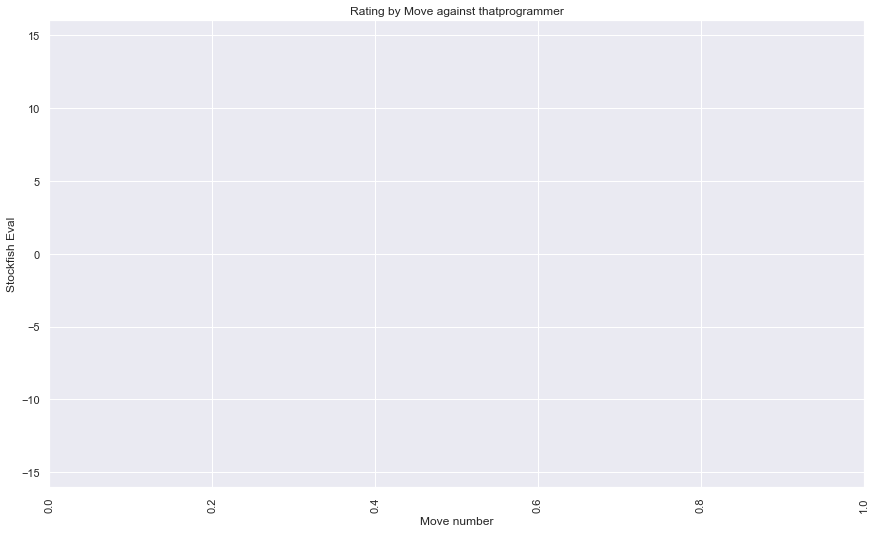

In [39]:
def stockfish_opp(df, opp):
    df = df[df["Opponent"] == opp].reset_index().drop(["level_0"], axis=1)
    stockfish_fn(df, opp, "opp")

stockfish_opp(stock_df, Opponent_name)

### 6.2&emsp;Opening vs Engine Evaluation

<br>

**Goal**: Analyze the patterns for how a game plays out with a specific opening. Is there any point in the game where the user often holds a lead but loses it? What typically happens after the opening finishes?

**Input**: Type in which color the user plays as and what opening they play.

<br>

In [40]:
# ex. Opening = "Sicilian Defense"

Opening = "Caro-Kann Defense"

# "White" or "Black"
User_plays_as = "Black"

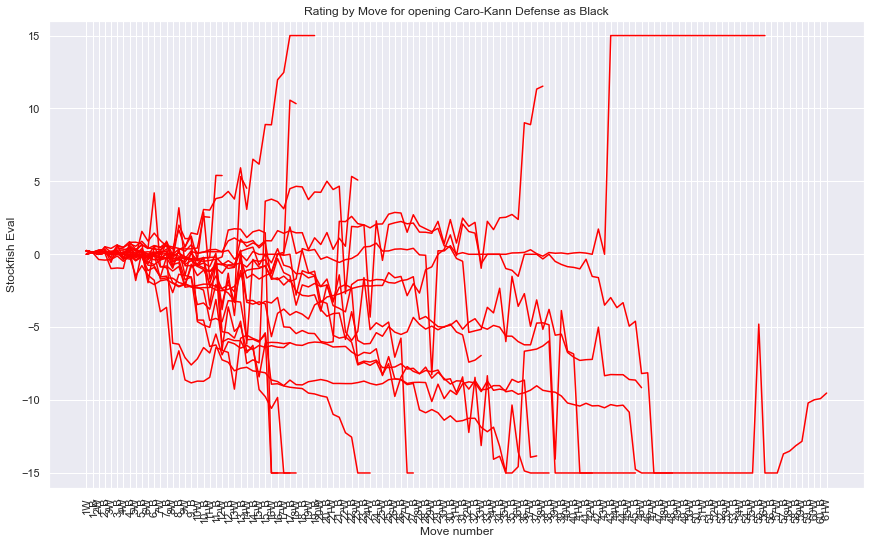

In [41]:
def stockfish_opening(df, opening, User_plays_as):
    df = df[df["Color"] == User_plays_as]
    df = df[df["Opening"] == opening].reset_index().drop(["level_0"], axis=1)
    stockfish_fn(df, opening, "opening", User_plays_as)

stockfish_opening(stock_df, Opening, User_plays_as)

<br>

### 6.3&emsp; Opening Variation vs Engine Evaluation

<br>

Considers all games of a specific opening variation (more in-depth version of the graphs from above).

#### There are two functions below:
**Function 1**. Graph all rating graphs under an opening, but have the ones played under the specified variation in CYAN. Same runtime as the graphs above.

&emsp;**Goal**: Compare the game flow for an opening variation versus all other variations in that opening.

**Function 2**. ONLY graph games with the given opening and variation.

&emsp;**Goal**: Same as 6.2, but for an opening variation.


#### Important: the variation is included in the PGN file as the part after the ":". If no ":" appears for a game entry, then the variation is simply considered "Main Line".
<br>

**Input**: type in which color the user plays as and what opening/variation below, then run the cell after.

<br>

In [42]:
# ex. Opening = "Four Knights Game"
# ex. Variation = "Italian Variation"

Opening = "Vienna Game"
Variation = "Vienna Gambit"

# "White" or "Black"
User_plays_as = "White"

<br>
<br>

**Function 1**: graphs all games under the opening but the ones under the variation are colored in **CYAN**.

<br>

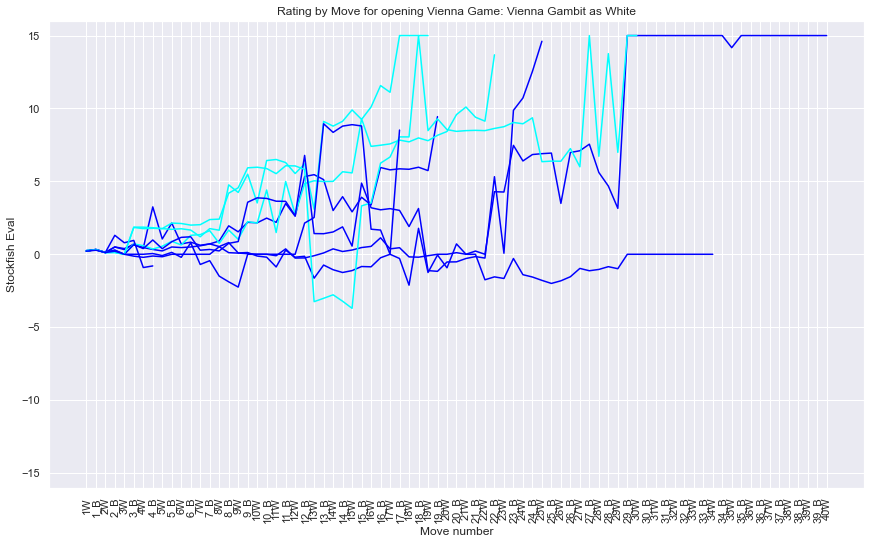

In [43]:
def stockfish_opening_variation(df, opening, variation, User_plays_as):
    df = df[df["Color"] == User_plays_as]
    df = df[df["Opening"] == opening].reset_index().drop(["level_0"], axis=1)
    stockfish_fn(df, opening + ": " + variation, "opvar", User_plays_as, variation)

stockfish_opening_variation(stock_df, Opening, Variation, User_plays_as)

<br>
<br>

**Function 2**: graphs ONLY games under the variation in addition to opening.

<br>

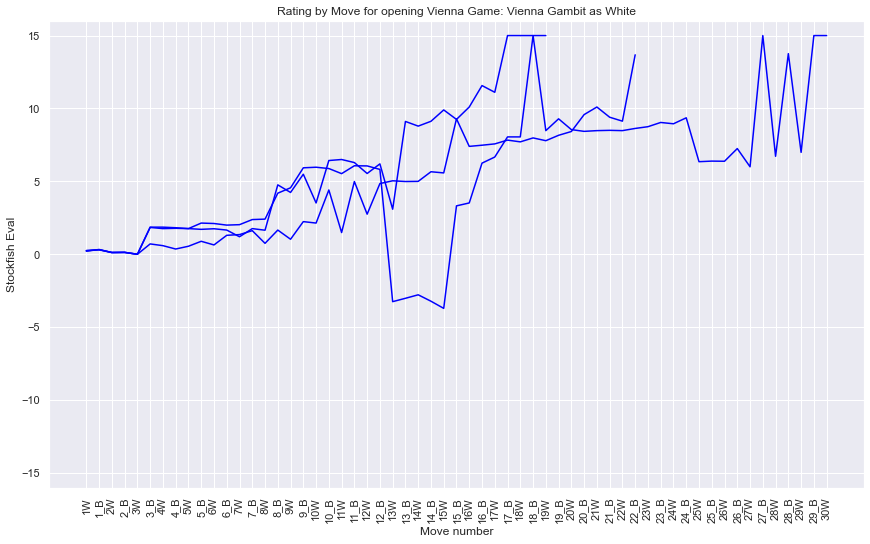

In [44]:
def stockfish_opening_variation_iso(df, opening, variation, User_plays_as):
    df = df[df["Color"] == User_plays_as]
    df = df[df["Opening"] == opening]
    df = df[df["Variation"] == variation].reset_index().drop(["level_0"], axis=1)
    stockfish_fn(df, opening + ": " + variation, "opening", User_plays_as, variation)

stockfish_opening_variation_iso(stock_df, Opening, Variation, User_plays_as)


### 6.4&emsp;Engine Evaluation on Piece Moved

<br>

**Goal**: What piece does the user blunder with the most? The table shows what pieces the user is good/bad with, and a "Total Gain" score that indicates the total amount of rating the user has gained on their opponents over all their piece moves. The graph shows where in the game they tend to blunder their pieces.

**Note**: It is better to have higher rating as White, and lower as Black. The reason it will be all negative for White and all positive for Black is because it is not possible to increase your evaluation score with a move (at best, you can only maintain the same engine evaluation). Of course, there will show instances where this happened because the data is not perfect.

(Optional) Note: On a more technical note, the "Total Gain" score is merely an estimate, not the real gain you get across all moves. The true total gain could be calculated by multiplying the user_count * avg_user_rating - opponent_count * avg_opponent_rating, but if the user tends to play much more bishop moves, then the total gain will probably be worse for the user (why? see above note). That's not because the user is worse with the piece but because they play it more often. Sure, the average rating already reflects this, so why does it matter? My intentions behind showing the "Total Gain" was to give users an idea of significant their average loss was compared to their opponents by factoring in how often the piece is played from both sides. For example, making mistakes on castling should result in low total gain because it can only be played once per game. I did not want to factor in how much a user chooses to move a piece vs how often their opponent does as well.

**Input**: Type in which color the user plays as and what opening they play.

<br>

In [45]:
# "White" or "Black"
user_color = "Black"

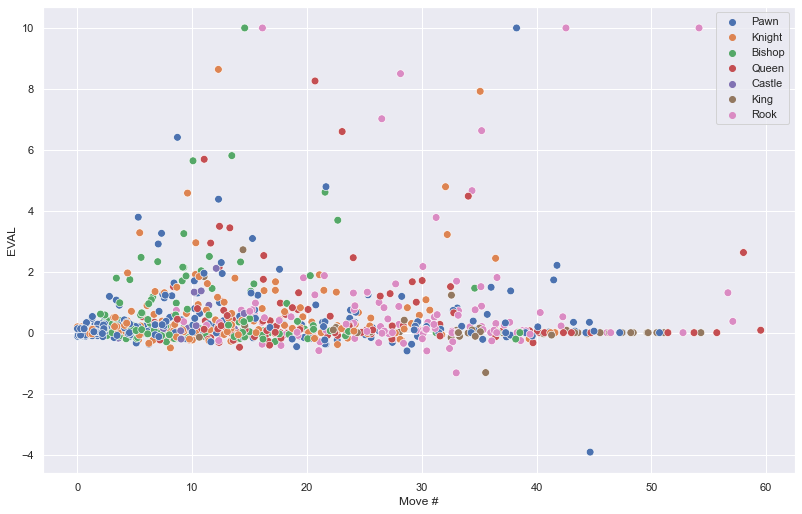

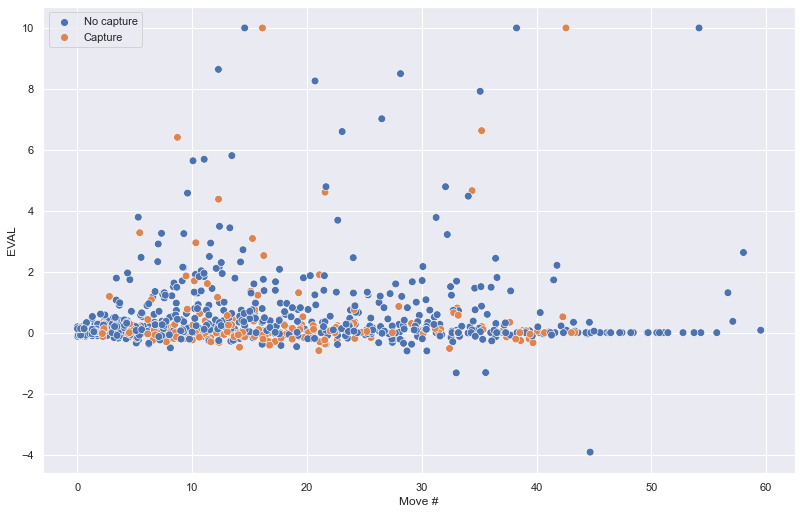

USER IS: Black
| Piece      |   Avg Rating |   Avg Opponent Rating |   Total Gain |   Count |   Opponent Count |
|:-----------|-------------:|----------------------:|-------------:|--------:|-----------------:|
| King       |         0.12 |                 -0.66 |       -32.67 |      44 |               77 |
| Queen      |         0.61 |                 -1.09 |       -47.76 |     113 |               86 |
| Rook       |         0.8  |                 -0.64 |        17.84 |     119 |              104 |
| Bishop     |         0.65 |                 -0.66 |        -1.32 |     127 |              137 |
| Knight     |         0.56 |                 -0.51 |         7.85 |     149 |              165 |
| Pawn       |         0.37 |                 -0.68 |       -73.16 |     236 |              236 |
| Castle     |         0.4  |                 -0.91 |       -10.46 |      20 |               21 |
| Capture    |         0.4  |                 -0.36 |         7.6  |     207 |              173 |
| No 

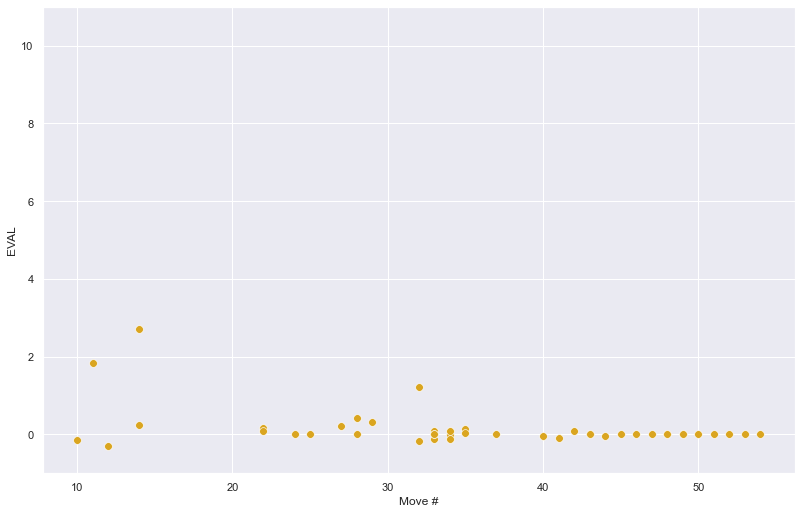



Queen Graph: 0.61, n=113


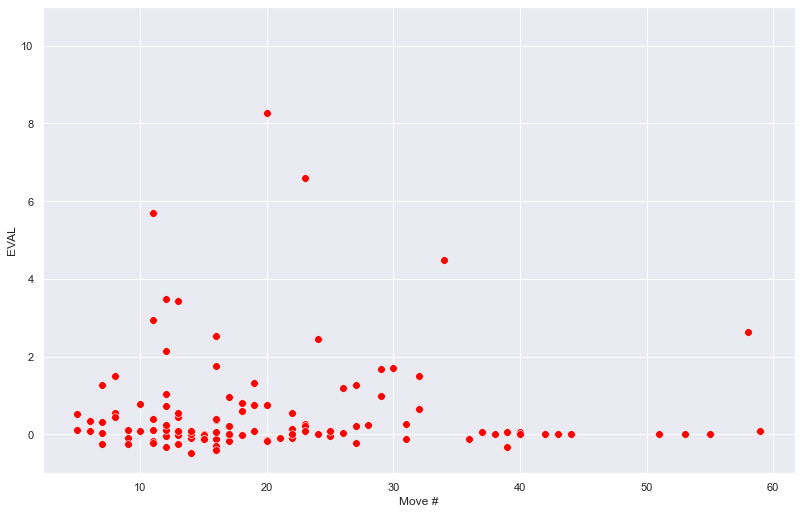



Rook Graph: 0.8, n=119


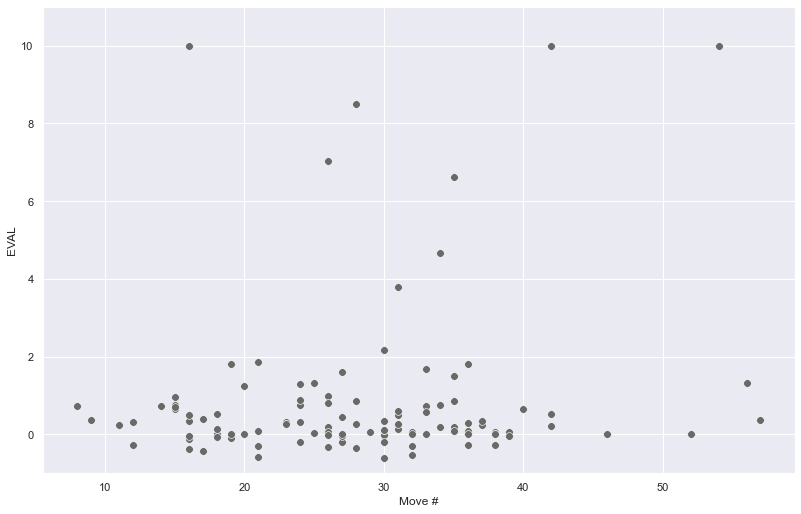



Bishop Graph: 0.65, n=127


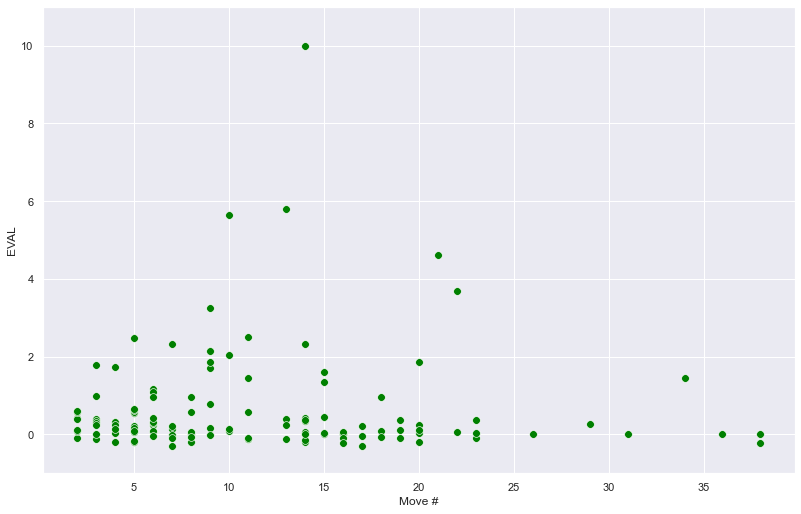



Knight Graph: 0.56, n=149


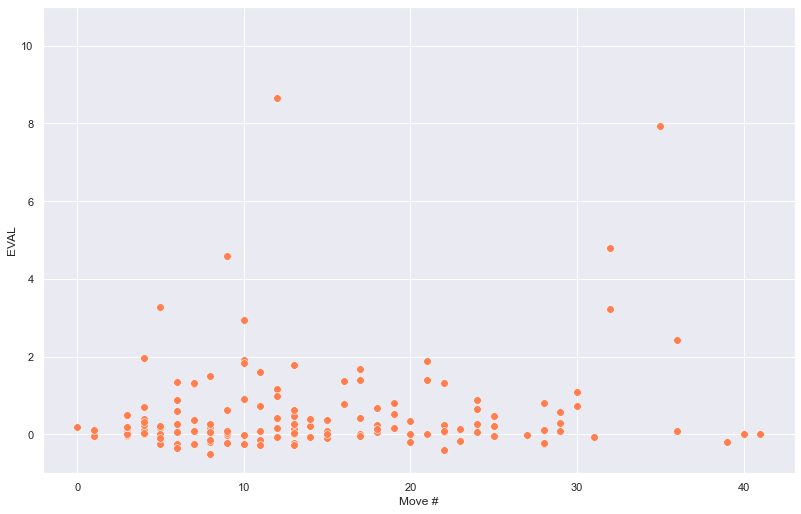



Pawn Graph: 0.37, n=236


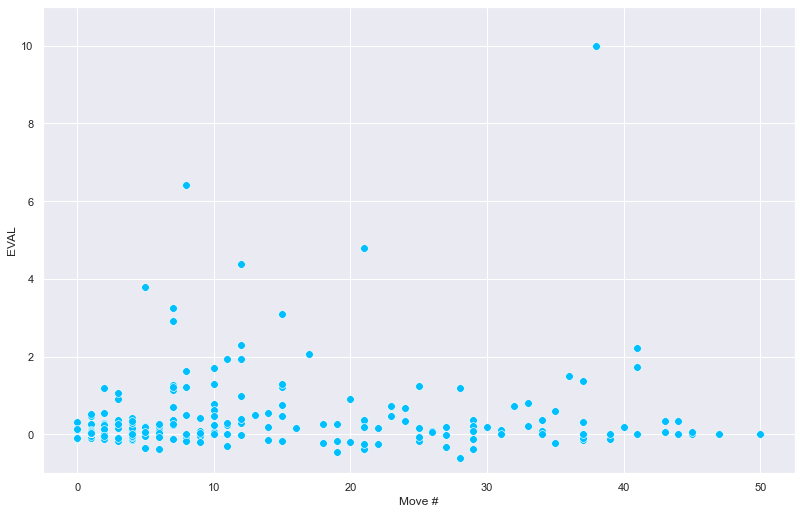



Castle Graph: 0.4, n=20


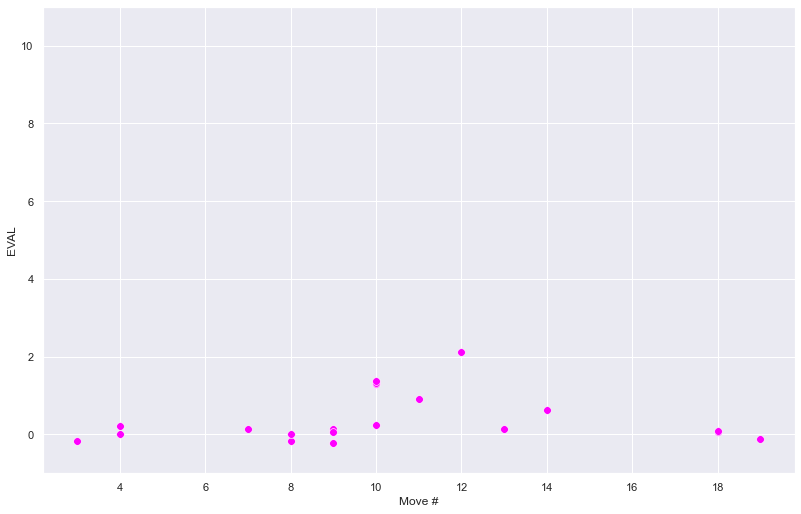

In [46]:
def move_rating(df, side):
    df = df[df["Color"] == side].reset_index()
    if (side == "White"):
        colrat = "WhiteRating"
        colmove = "WhiteMoves"
        enemyrat = "BlackRating"
        enemymove = "BlackMoves"
        bottomLimit = -11
        upperLimit = 1
        maxRat = -10
    elif (side == "Black"):
        colrat = "BlackRating"
        colmove = "BlackMoves"
        enemyrat = "WhiteRating"
        enemymove = "WhiteMoves"
        bottomLimit = -1
        upperLimit = 11
        maxRat = 10
    else:
        raise ValueError("Invalid input.")
        
    turn = []
    rating = []
    piece = []
    capture=[]
    # for the table below the graphs
    K, Q, R, B, N, C, P, X, NX = [], [], [], [], [], [], [], [], []
    
    for j in np.arange(len(df[colrat])):
        for i in np.arange(len(df[colrat][j])):
            # Added x_jitter by random (0, 0.4)
            turn.append(i + np.random.rand() * 0.8)
            if (abs(df[colrat][j][i]) > 10):
                rating.append(maxRat)
            else:
                rating.append(df[colrat][j][i])
            
            # movedPiece represents the piece moved already with [0] 
            # taking the first character of the string. 
            # ex. 'B' from 'Bc4'
            movedPiece = df[colmove][j][i][0]
            capturePiece = df[colmove][j][i][1]
            
            
            if (movedPiece == 'K'):
                piece.append('King')
                K.append(rating[-1])
            elif (movedPiece == 'Q'):
                piece.append('Queen')
                Q.append(rating[-1])
            elif (movedPiece == 'R'):
                piece.append('Rook')
                R.append(rating[-1])
            elif (movedPiece == 'B'):
                piece.append('Bishop')
                B.append(rating[-1])
            elif (movedPiece == 'N'):
                piece.append('Knight')
                N.append(rating[-1])
            elif (movedPiece == 'O'):
                piece.append('Castle')
                C.append(rating[-1])
            else:
                piece.append('Pawn')
                P.append(rating[-1])
            
            if (capturePiece == 'x'):
                capture.append('Capture')
                X.append(rating[-1])
            else:
                capture.append('No capture')
                NX.append(rating[-1])
                
                
    # added this way after or probably would've written differently
    e_turn = []
    e_rating = []
    e_piece = []
    e_capture=[]
    eK, eQ, eR, eB, eN, eC, eP, eX, eNX = [], [], [], [], [], [], [], [], []
    
    for j in np.arange(len(df[enemyrat])):
        for i in np.arange(len(df[enemyrat][j])):
            # Added x_jitter by random (0, 0.4)
            e_turn.append(i)
            if (abs(df[enemyrat][j][i]) > 10):
                e_rating.append(maxRat * -1)
            else:
                e_rating.append(df[enemyrat][j][i])
            
            # movedPiece represents the piece moved already with [0] 
            # taking the first character of the string. 
            # ex. 'B' from 'Bc4'
            e_movedPiece = df[enemymove][j][i][0]
            e_capturePiece = df[enemymove][j][i][1]
            
            
            if (e_movedPiece == 'K'):
                e_piece.append('King')
                eK.append(e_rating[-1])
            elif (e_movedPiece == 'Q'):
                e_piece.append('Queen')
                eQ.append(e_rating[-1])
            elif (e_movedPiece == 'R'):
                e_piece.append('Rook')
                eR.append(e_rating[-1])
            elif (e_movedPiece == 'B'):
                e_piece.append('Bishop')
                eB.append(e_rating[-1])
            elif (e_movedPiece == 'N'):
                e_piece.append('Knight')
                eN.append(e_rating[-1])
            elif (e_movedPiece == 'O'):
                e_piece.append('Castle')
                eC.append(e_rating[-1])
            else:
                e_piece.append('Pawn')
                eP.append(e_rating[-1])
            
            if (e_capturePiece == 'x'):
                e_capture.append('Capture')
                eX.append(e_rating[-1])
            else:
                e_capture.append('No capture')
                eNX.append(e_rating[-1])
    
    ax = plt.subplot()
    sns.set(rc={'figure.figsize':(12, 8)})
    sns.scatterplot(x=turn, y=rating, hue=piece, s=60)
    plt.xlabel("Move #")
    plt.ylabel("EVAL")
    plt.show()
    
    ax = plt.subplot()
    sns.set(rc={'figure.figsize':(12, 8)})
    sns.scatterplot(x=turn, y=rating, hue=capture, s=60)
    plt.xlabel("Move #")
    plt.ylabel("EVAL")
    plt.show()
    
    # Print table
    print("USER IS: " + side)
    
    looper = [[K, eK, "King"], [Q, eQ, "Queen"], [R, eR, "Rook"], [B, eB, "Bishop"], 
              [N, eN, "Knight"], [P, eP, "Pawn"], [C, eC, "Castle"], [X, eX, "Capture"], [NX, eNX, "No capture"]]
    piece_df = {"Piece":[], "Avg Rating":[], "Avg Opponent Rating":[], "Total Gain":[], "Count":[], "Opponent Count":[]}
    piece_df = pd.DataFrame(piece_df)
    for i in looper:
        new_row = {"Piece":i[2], "Avg Rating":round(np.average(i[0]), 2),  
                  "Avg Opponent Rating":round(np.average(i[1]), 2), 
                  "Total Gain":round((round(np.average(i[0]), 2) + round(np.average(i[1]), 2)) * (len(i[0]) + len(i[1])) / 2, 2),
                  "Count":len(i[0]),
                  "Opponent Count":len(i[1])}
        piece_df = piece_df.append(new_row, ignore_index = True)

    
    print(piece_df.set_index("Piece").to_markdown())
    
    
    for i in np.arange(6):
        print()
    
    
    
    # Individual plots now
    idf = pd.DataFrame([turn, rating, piece]).transpose()
    idf[1] = idf[1].astype(float)
    idf[0] = idf[0].astype(int)
    colors = ['goldenrod', 'red', 'dimgray', 'green', 'coral', 'deepskyblue', 'fuchsia']
    colorsCount = 0
    
    for i in ['King', 'Queen', 'Rook', 'Bishop', 'Knight', 'Pawn', 'Castle']:
        temp_idf = idf[idf[2] == i]
        
        print(i + " Graph: " + str(round(np.average(temp_idf[1]), 2)) + ", n=" + str(len(temp_idf)))
        ax = plt.subplot()
        sns.set(rc={'figure.figsize':(12, 8)})
        sns.scatterplot(x=temp_idf[0], y=temp_idf[1], s=60, color=colors[colorsCount])
        plt.xlabel("Move #")
        plt.ylabel("EVAL")
        plt.ylim(bottomLimit, upperLimit)
        plt.show()
        print("")
        print("")
        
        colorsCount += 1
    

move_rating(stock_df, user_color)

<br>

### 6.5&emsp;Specified Eval + Move Number Statistics

<br>

Given a certain eval rating and a move number, what is the winrate for the user?

**Goal**: There's not much to see here, but maybe you might find that your winrate is horrificly low under a certain engine evaluation, like -2 (indicating that you give up too easily). Or that you choke through leads a lot. Besides that, it's just a fun tool to try out.


**Important**: In addition to outputting winrate, you can also optionally output a dataframe and a list that shows the index of the games where the user converted a win or loss. For example, if you wanted to see games where you came back from a -5 engine evaluation, you could use the list of indices / dataframe and match them with your CSV. To match the indices with the CSV, you will have to add 2 to each index (the actual CSV file's first entry is at row 2, while it is 0 in our dataframe).

**Inputs**: A lot! Check the cell below for instructions.
<br>
<br>

In [47]:
# Inputs here

# Any number works (up to abs(15))
EVAL_RATING = -1.2

# Type either "range" or "split"
range_or_split = "range"

# Range for eval rating. If EVAL_RATING = 1.4 and EVAL_RANGE = 0.2, then it finds 
# games between 1.2 and 1.6 rating (inclusive).
# MUST BE POSITIVE!
EVAL_RANGE = 0.5

# Split for eval rating. If EVAL_RATING = 1.4 and SPLIT_UP = True, then take 
# all evals greater than or equal to 1.4. If SPLIT_UP = False, then take those below or equal.
SPLIT_UP = True

# Specify move number
MOVE_NUMBER = 5

# "White" or "Black"
user_color = "White"





# Optional: output indices + a dataframe of the games in this eval range. 

# Set to True or False.
output = True

# Type "Win", "Loss", or "Draw"
# in output_result for only games that were won, lost, or drawn, or anything
# else for all games.
output_result = "Win"

<br>
After inputs are ready, run the cell below.
<br>

In [48]:
def eval_move(df, eval_rating, range_or_split, eval_range, split_up, move_number, output, side, output_result):
    
    df = df[df["Color"] == side].reset_index().drop(["level_0"], axis=1)
    
    if (side == "White"):
        ratin = "WhiteStockfish"
    elif (side == "Black"):
        ratin = "BlackStockfish"
    else:
        raise ValueError("Invalid Input on user_color.")
    
    droplist = []
    if (range_or_split == "range"):
        for i in np.arange(len(df[ratin])):
            
            if (len(df[ratin][i]) < move_number):
                droplist.append(i)

            elif (abs(df[ratin][i][move_number - 1] - eval_rating) > eval_range):
                #print(df[ratin][i][move_number - 1])
                droplist.append(i)
    
    elif (range_or_split == "split"):
        for i in np.arange(len(df[ratin])):
            if (len(df[ratin][i]) < move_number):
                droplist.append(i)
            elif (split_up and (df[ratin][i][move_number - 1] < eval_rating)):
                droplist.append(i)
            elif ((split_up == False) and (df[ratin][i][move_number - 1] > eval_rating)):
                droplist.append(i)
    else:
        raise ValueError("Invalid Input on range_or_split.")
        
    df = df.drop(df.index[droplist]).reset_index().drop(["level_0"], axis=1)
    
    for i in np.arange(len(df[ratin])):
        df[ratin][i] = df[ratin][i][move_number - 1]
    
    print(color.GREEN + "Eval Range: " + str(eval_rating - eval_range) + " <-> " + str(eval_rating + eval_range))
    print("Move Number: " + str(move_number))
    wl_helper(df, side)
    mean = np.mean(df["OpponentRating"])
    print("AVG ELO:\t" + str(round(mean, 3)))
    
    if (output == True):
        print("------------------")
        print("")
    
        if (output_result == "Win"):
            df = df[df["Win"] == 1]
        elif (output_result == "Loss"):
            df = df[df["Loss"] == 1]
        elif (output_result == "Draw"):
            df = df[df["Draw"] == 1]
        else:
            output_result = "All"
    
        print(color.END + "Indices from original dataframe (read right column) for " + output_result + ":")
        print(df["index"])
        return df
            
    
eval_move(stock_df, EVAL_RATING, range_or_split, EVAL_RANGE, SPLIT_UP, MOVE_NUMBER, output, user_color, output_result)

Eval Range: -1.7 <-> -0.7
Move Number: 5
White
GP:		0
Record:		0-0-0
PPG:		0
AVG ELO:	nan
------------------

Indices from original dataframe (read right column) for Win:
Series([], Name: index, dtype: int64)


Empty DataFrame
Columns: [index, Year, Month, Day, Color, Result, Moves, Opponent, Opening, Variation, ECO, ECO1, ECO2, Time, Increment, Event, Rating, OpponentRating, RatingChange, WhiteMoves, BlackMoves, WhiteRating, BlackRating, WhiteStockfish, BlackStockfish, WhiteSeconds, BlackSeconds, WhiteMinutes, BlackMinutes, WhiteTotalSeconds, BlackTotalSeconds, WhiteTotalMinutes, BlackTotalMinutes, Win, Loss, Draw, Site, UTCDate, UTCTime, Termination]
Index: []

[0 rows x 40 columns]

<a id='time'></a>
<br>
<br>

## 7. Time Analysis

<br>

Everything to do with clock times. 

<br>

Covers:

&emsp;**7.0**. Setup

&emsp;**7.1**. Move # vs Time Spent

&emsp;**7.2**. Move # vs Time Remaining

&emsp;**7.3**. Engine Evaluation vs Time Spent

&emsp;**7.4**. Move Rating vs Time Spent

&emsp;**7.5**. Piece Moved vs Time Spent

<br>

(Optional) Note: I was going to add something time control + increment related as well but the reason I didn't was because I don't think showing time+increment vs winrate shows anything significant. Having a lower winrate in 5 minute games versus 15 minute games is more of a Blitz vs Classical issue, and the equivalent rating in Blitz and Classical are not the same, ex. a 1500 player in Blitz is better than a 1500 player in Classical.

<br>


<br>

### 7.0&emsp;Setup

<br>

Like with before, many games won't have time evals either, so filter by games that have time evals.

<br>
<br>

In [49]:
def filter_time(df):
    droplist = []
    for i in np.arange(len(df["WhiteMinutes"])):
        if (df["WhiteMinutes"][i] == []):
            droplist.append(i)
    
    df = df.drop(df.index[droplist]).reset_index()
    return df

time_df = filter_time(df)

<br>
The general function needed for all the time graphs below. At the bottom of the cell below, specify what mode or time control + increment you want to look at for time analysis. If you want to include all games for any of them, just leave the variable as a "", ex. time = "". If you want a 10+5 control, then set time=10 and increment=5.

<br>

Note: the PGN often didn't provide moves or ratings past move 99, so they any 100+ move/ratings likely won't appear in the graphs later.
<br>
<br>

In [50]:
def time_fn(df, mode, time, increment):
    if (mode != ""):
        df = df[df["Event"] == mode].reset_index().drop(["level_0"], axis=1) 
    if (time != ""):
        df = df[df["Time"] == time].reset_index().drop(["level_0"], axis=1)
    if (increment != ""):
        df = df[df["Increment"] == increment].reset_index().drop(["level_0"], axis=1)
    
    if (len(df) == 0):
        print("No games found.")
        return
    
    user = []
    move = []
    timeSpent = []
    timeLeft = []
    pieces = []
    
    # The reason this is needed instead of just using timeSpent is because of an edge
    # case where checkmate happens instead of a forfeit/time-out. The clock will update for
    # the very last move, but no eval is shown, so the lengths of the two arrays will mismatch.
    timeStock = []
    stockfish = []
    ratin = []
    
    gameCount = 0
    
    dualColor = ["White", "Black"]
    dualSeconds = ["WhiteSeconds", "BlackSeconds"]
    dualTotalMinutes = ["WhiteTotalMinutes", "BlackTotalMinutes"]
    dualStockfish = ["WhiteStockfish", "BlackStockfish"]
    dualRatin = ["WhiteRating", "BlackRating"]
    dualPieces =["WhiteMoves", "BlackMoves"]
             
    for k in np.arange(2):
        for i in np.arange(len(df[dualSeconds[k]])):
            lenstock = len(df[dualStockfish[k]][i])
            gameCount += 1
            
            # Check if user is White for every game
            if (df["Color"][i] == dualColor[k]):
                side = "Self"
            else:
                side = "Opponent"
                
            # Check if stockfish %eval is included for this game (i).
            if (df[dualStockfish[k]][i] == []):
                stockInclude = False
            else:
                stockInclude = True
                      
            for j in np.arange(len(df[dualSeconds[k]][i])):
                
                if (df[dualPieces[k]][i][j] != ""):
                    user.append(side)
                    move.append(j)
                    timeSpent.append(df[dualSeconds[k]][i][j])
                    timeLeft.append(df[dualTotalMinutes[k]][i][j])

                    try:
                        movedPiece = df[dualPieces[k]][i][j][0]
                    except IndexError:
                        print(i)
                        print(j)
                        print(df[dualPieces[k]][i])
                    if (movedPiece.islower()):
                        movedPiece = 'P'
                    pieces.append(movedPiece)
                
                if ((stockInclude == True) and (j < lenstock - 1)):
                    timeStock.append(df[dualSeconds[k]][i][j])
                    stockfish.append(df[dualStockfish[k]][i][j])
                    ratin.append(df[dualRatin[k]][i][j])
                



    idf = pd.DataFrame([move, timeSpent, timeLeft, user, stockfish, timeStock, ratin, pieces]).transpose()
    idf[0] = idf[0].astype(int)
    idf[1] = idf[1].astype(float)
    idf[2] = idf[2].astype(float)
    idf[4] = idf[4].astype(float)
    idf[5] = idf[5].astype(float)
    idf[6] = idf[6].astype(float)
    idf = idf.rename(columns={0:"move", 1:"timeSpent", 2:"timeLeft", 3:"user", 4:"stockfish",
                             5:"timeSpentStockfish", 6:"rating", 7:"pieces"})

    return idf, gameCount, stockfish
    


# EDIT HERE
mode = ""
time = ""
increment = ""


    
    
ta_df, gameCount, stock_time = time_fn(time_df, mode, time, increment)

<br>

### 7.1&emsp;Move # vs Time Spent

<br>

Compares the average time per move for a user and all opponents they played against.

**Goal**: See where in the game the user typically spends the most time thinking, and how they compare overall against opponents.


<br>


Game Count: 51.0



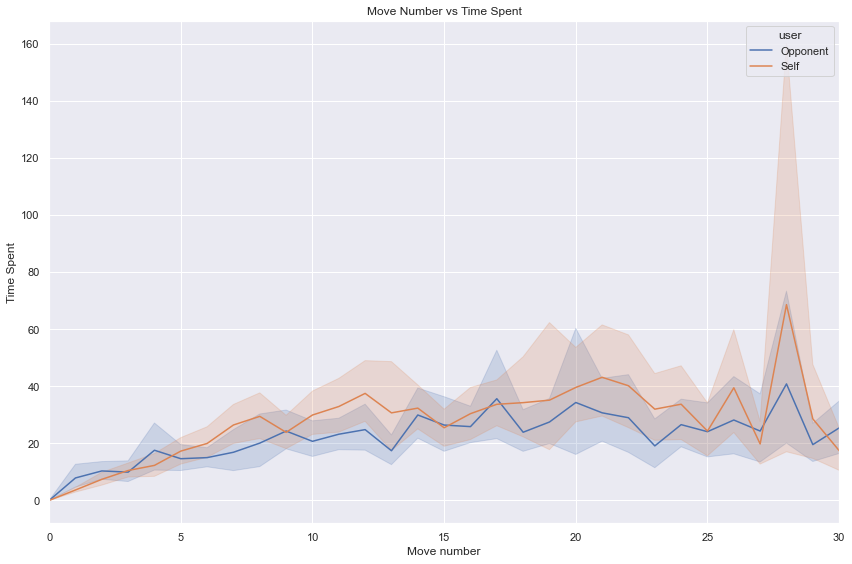

In [51]:
print()
print(color.BOLD + "Game Count: " + str(gameCount / 2) + color.END)
print()

sns.lineplot(data=ta_df, x="move", y="timeSpent", hue="user", estimator=np.mean)
plt.xlabel("Move number")
plt.ylabel("Time Spent")
plt.xlim(0, 30)
plt.title("Move Number vs Time Spent")
plt.tight_layout()
plt.show()

<br>

### 7.2&emsp;Move # vs Time Remaining

<br>

Compares the average time left for a user and all opponents they played against.

**Goal**: See how a user chooses to budget their time in a game.


<br>


Game Count: 51.0



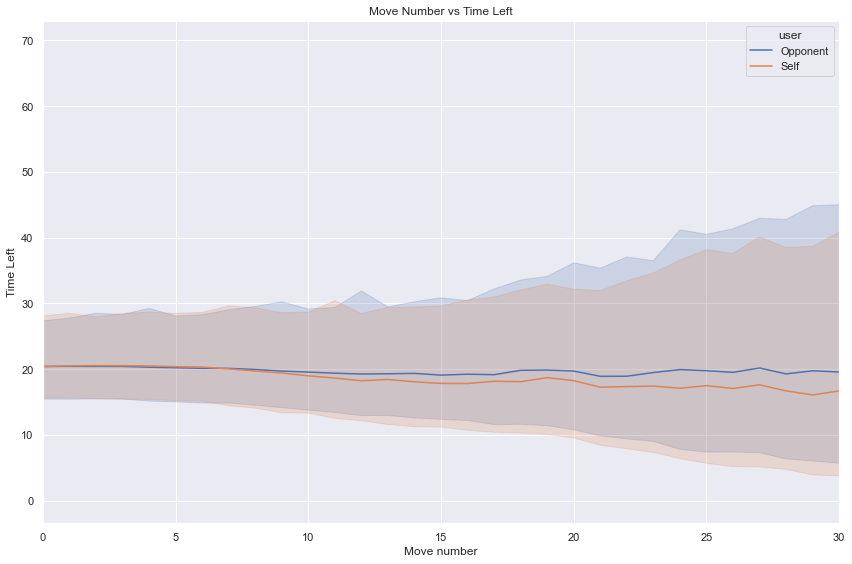

In [52]:
print()
print(color.BOLD + "Game Count: " + str(gameCount / 2) + color.END)
print()


sns.lineplot(data=ta_df, x="move", y="timeLeft", hue="user", estimator=np.mean)
plt.xlabel("Move number")
plt.ylabel("Time Left")
plt.xlim(0, 30)
plt.title("Move Number vs Time Left")
plt.tight_layout()
plt.show()

<br>

### 7.3&emsp;Engine Evaluation vs Time Spent

<br>

Compares the current engine evaluation and how much time is spent on that move.

**Goal**: There's not much "good" or "bad" to see from this graph, but a difference between the user and opponent may say something about the user's habits when they are up or down on in the game.


<br>

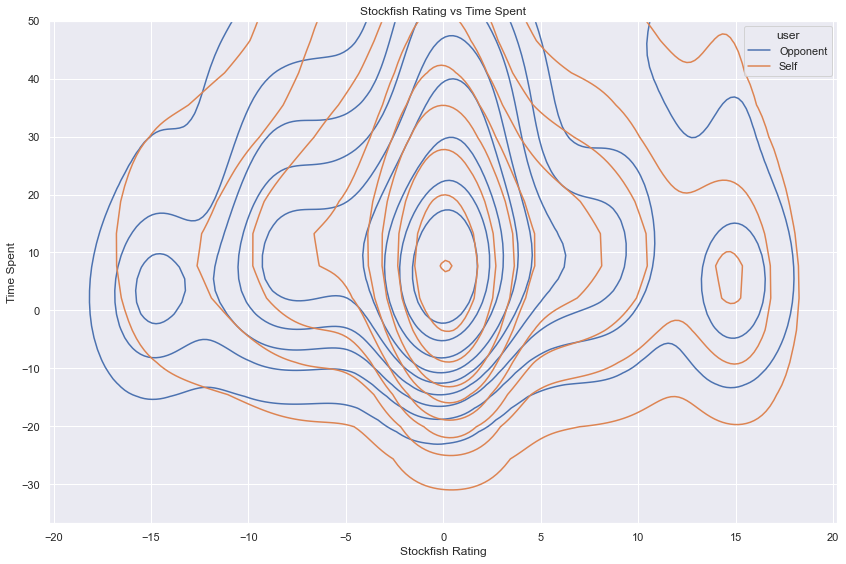

In [53]:
if (len(stock_time) == 0):
        print("No games found with stockfish.")
else:
    sns.kdeplot(data=ta_df, x="stockfish", y="timeSpentStockfish", hue="user")
    plt.xlabel("Stockfish Rating")
    plt.ylabel("Time Spent")
    plt.title("Stockfish Rating vs Time Spent")
    plt.tight_layout()
    
    # Adjust the value if needed
    plt.ylim(top=50)
    
    plt.show()

<br>

### 7.4&emsp;Move Rating vs Time Spent

<br>

Compares the move's engine rating and how much time is spent on that move.

**Goal**: The focus on this graph is in the bad moves, or moves with negative ratings. Does the user typically spend less time thinking before making those moves? Or do they think a long time and still make the wrong move? Blunders are hard to make with a lot of thought, so if the user's curve is under the opponent's curve then they aren't spending enough time on moves (resulting in blunders).


<br>

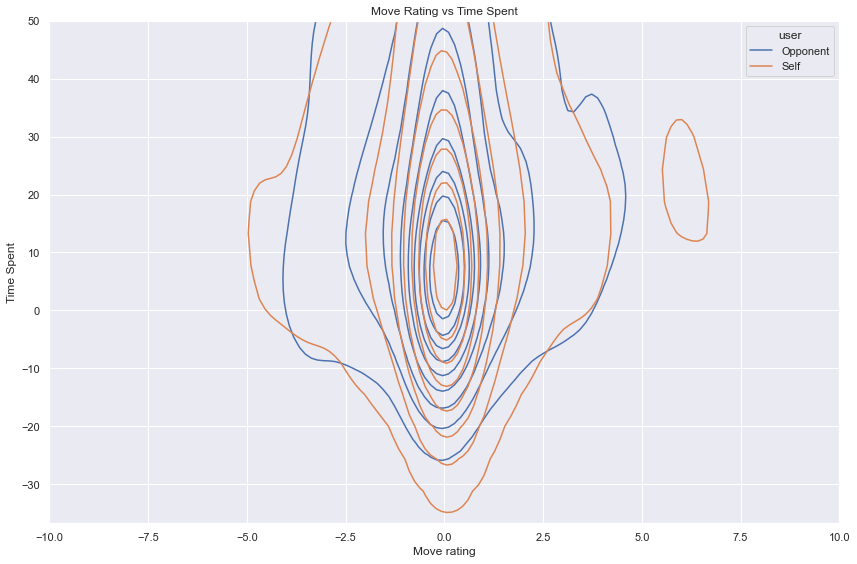

In [54]:
if (len(stock_time) == 0):
    print("No games found with stockfish.")
else:
    sns.kdeplot(data=ta_df, x="rating", y="timeSpentStockfish", hue="user")
    plt.xlabel("Move rating")
    plt.ylabel("Time Spent")
    plt.title("Move Rating vs Time Spent")
    plt.tight_layout()
    
    # Adjust the value if needed
    plt.xlim(-10, 10)
    plt.ylim(top=50)
    
    plt.show()

<br>


### 7.5&emsp;Piece Moved vs Time Spent

<br>

Produces a graph for each piece and graphs move number vs the amount of time is spent in moving that piece.

**Goal**: There are many graphs here and the lines aren't very clear, but any extremely noticeable patterns indicate that the user has a particular habit with regards to moving a certain piece at a certain point in the game.


<br>

PIECE: B


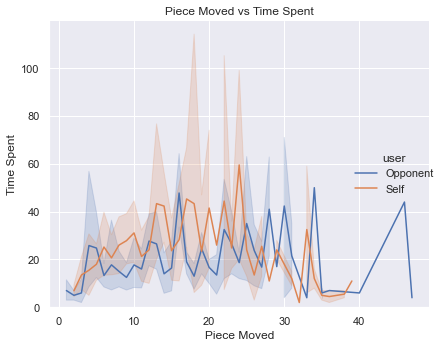

PIECE: K


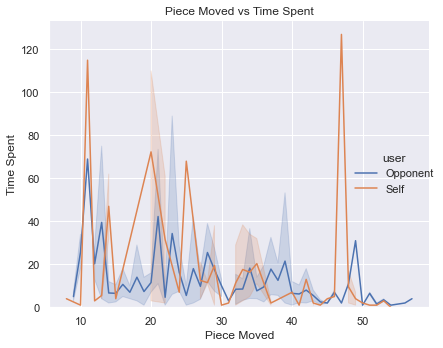

PIECE: N


PIECE: O


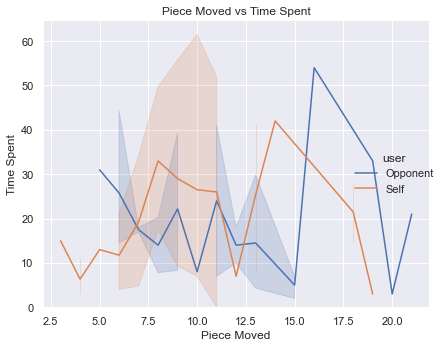

PIECE: P


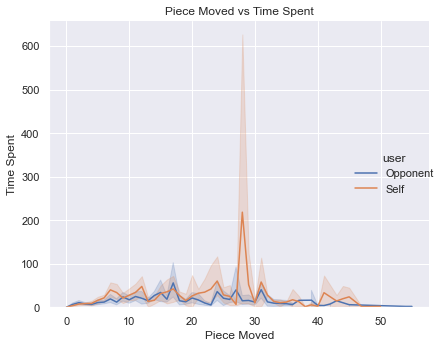

PIECE: Q


PIECE: R


In [55]:
uniquePieceList = np.unique(ta_df["pieces"])
for i in uniquePieceList:
    temp_idf = ta_df[ta_df["pieces"] == i]
    print("PIECE: " + i)
    sns.relplot(data=temp_idf, x="move", y="timeSpent", hue="user", kind="line")
    plt.xlabel("Piece Moved")
    plt.ylabel("Time Spent")
    plt.ylim(bottom=0)
    plt.title("Piece Moved vs Time Spent")
    plt.tight_layout()
    plt.show()

<a id='szn'></a>
<br>
<br>

## 8. Seasons

<br>

Covers:

&emsp;**8.1**. Seasons

&emsp;**8.2**. Season Graphs

<br>

Feel free to skip this section, it's a very specific system that tracks data more than it really shows anything. Or you can run it if you want.

How I play rated on Lichess: every "season" consists of N=50 rated games, where I play in a specific rating range of range 150 (max - min) for Classical/Rapid only. After 50 games, the PPG (points per game) I get determines whether I keep the range the same, or promote/demote the range by +/-(50 * n) ELO points. For example, I might be playing on 1550-1700 in one season, and after promoting on a 29-19-2 season, I would be playing in the 1600-1750 range the next season. 

**Goal**: Of course, since nobody else probably plays like this, the information above won't be very useful. Instead, what you can get out of this section is your performance for every N games (and especially, the most recent N games). It may also show how a user's opening repertoire has changed over time.

<br>
Note: used recursion to have the most recent season print first.

**Inputs**: N represents how long a season is (or every N games to show), and startELO and endELO represent the starting range for the first season.

<br>

In [56]:
N = 40


startELO = 1550
endELO = 1700

<br>

### 8.1&emsp;Seasons

<br>

In [57]:
def season_fn(df, start, end, season, gp):
    
    
    df = df.sort_values(["Year", "Month"], ascending = (False, False))
    
    bottom = max(gp - N, 0)
    score = np.sum(df[bottom: gp]["Win"]) + 0.5 * np.sum(df[bottom: gp]["Draw"])
    
    old_start = start
    old_end = end
    
    x, y, z = [], [], []
    
    lvl1, lvl2, lvl3 = 0.55, 0.61, 0.67
    # 22, 24.5, 27
    # 
    # 18, 15.5, 13

    if (gp >= N):
        promote = ""
        magnitude = ""
        if (score >= N * lvl1):
            promote = "PROMOTION "
            magnitude = "+50"
            start += 50
            end += 50
            if (score >= N * lvl2):
                magnitude = "+100"
                start += 50
                end += 50
                if (score >= N * lvl3):
                    magnitude = "+150"
                    start += 50
                    end += 50
        if (score <= N * (1 - lvl1)):
            promote = "DEMOTION "
            magnitude = "-50"
            start -= 50
            end -= 50
            if (score <= N * (1 - lvl2)):
                magnitude = "-100"
                start -= 50
                end -= 50
                if (score <= N * (1 - lvl3)):
                    magnitude = "-150"
                    start -= 50
                    end -= 50

        df50 = df[gp - N: gp]
    
        x, y, z = season_fn(df[0: gp - N], start, end, season + 1, gp - N)
    
    else:
        df50 = df
        promote = ""
        magnitude = ""
        
    x.append(season)
    y.append(np.mean(df["OpponentRating"]))
    z.append(score)
    
    wl_season(df50, "Season " + str(season), promote, magnitude, old_start, old_end, score)


    white = df50[df50["Color"] == "White"]
    black = df50[df50["Color"] == "Black"]


    print(color.BOLD + "WHITE:" + color.END)
    print(opening_list(white).iloc[0:5, [0, 2, 3, 4, 1, 8, 7]].to_markdown())

    print(color.BOLD + "BLACK:" + color.END)
    print(opening_list(black).iloc[0:5, [0, 2, 3, 4, 1, 8, 7]].to_markdown())
    print("")
    print("")
    print("")
    print("")

    gp -= N
    
    return x, y, z
        
        
def wl_season(data, event, promote, magnitude, start, end, score):
    
    print(color.UNDERLINE + color.DARKCYAN + event + color.END)
    print(color.RED + "Division:\t" + color.GREEN + str(start) + "-" + str(end))
    
    wl_helper(data, color.RED + "PTS:\t\t" + color.GREEN + str(score))
    
    mean = np.mean(data["OpponentRating"])
    print("AVG ELO:\t" + str(round(mean, 3)))
    
    if (promote != ""):
        print(color.PURPLE + promote + magnitude)
        
    print(color.END)


    
season_output = season_fn(df, startELO, endELO, 1, len(df))

Season 2
Division:	1600-1750
PTS:		9.0
GP:		11
Record:		9-2-0
PPG:		0.818
AVG ELO:	1687.0

WHITE:
| Opening           |   GP |   Win |   Loss |   Draw |   Moves |   Rating Difference |   Total Rating Gain |
|:------------------|-----:|------:|-------:|-------:|--------:|--------------------:|--------------------:|
| Vienna Game       |    2 |     2 |      0 |      0 |    29.5 |                  58 |                  27 |
| Caro-Kann Defense |    1 |     1 |      0 |      0 |    13   |                 144 |                  11 |
| French Defense    |    1 |     1 |      0 |      0 |    25   |                  34 |                  14 |
| King's Pawn Game  |    1 |     1 |      0 |      0 |    23   |                  78 |                  26 |
BLACK:
| Opening             |   GP |   Win |   Loss |   Draw |   Moves |   Rating Difference |   Total Rating Gain |
|:--------------------|-----:|------:|-------:|-------:|--------:|--------------------:|--------------------:|
| Caro-Kann Defense

<br>

### 8.2&emsp;Season Graphs

<br>

The following cell plots the season in the x-axis, the average opponent ELO in the y-axis, and the score (wins + 0.5 * draws) in the z-axis. These were defined as x, y and z in the previous function and returned as the output of season_fn.

<br>

**Non-interactive version**:

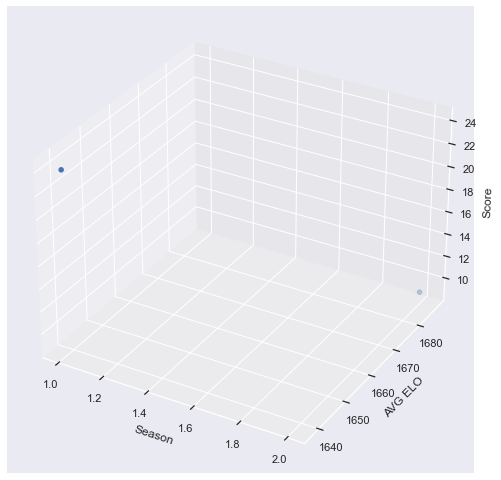

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = season_output[0]
y = season_output[1]
z = season_output[2]

ax.set_xlabel("Season")
ax.set_ylabel("AVG ELO")
ax.set_zlabel("Score")

ax.scatter(x, y, z)

plt.show()

**Interactive version**:

In [59]:
fig = px.scatter_3d(x=season_output[0], y=season_output[1], z=season_output[2],
                    range_x = [-3, max(x) + 3], range_y = [min(y) - 100, max(y) + 100], range_z = [-5, 55],
                   labels={
                     "x": "Season",
                    "y":"AVG ELO",
                       "z":"Score"
                     },
                    title="Opponent Elo vs W/L by Season")
fig.show()

**2D version**:

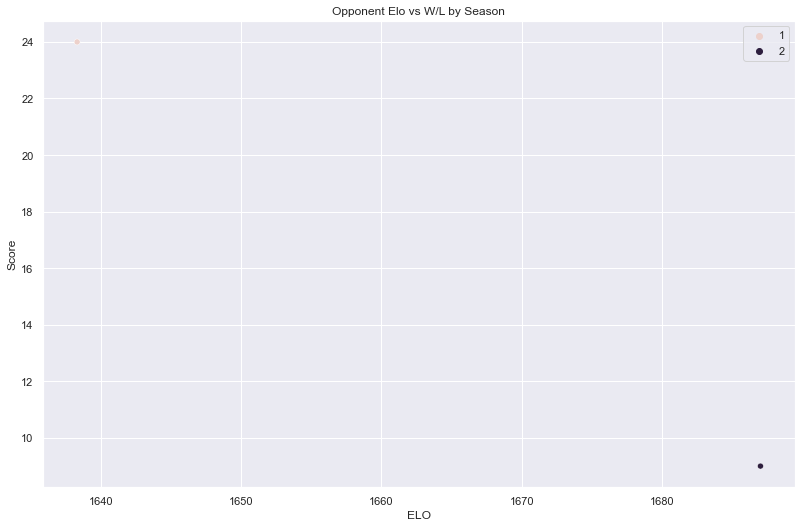

In [60]:
#plt.figure(figsize=(13,8))

ax = sns.scatterplot(x=season_output[1], y=season_output[2], hue=season_output[0])
plt.draw()

plt.xlabel("ELO")
plt.ylabel("Score")
plt.title("Opponent Elo vs W/L by Season")
plt.show()


<a id='log'></a>
<br>
<br>

## 9. Win Predictor using PCA + Multinomial Logistic Regression

<br>
    
Covers:

&emsp;**9.0**. PCA + Model

&emsp;**9.1**. Model 1: Predictor using model_df

&emsp;**9.2**. Model 2: Predictor without game knowledge

&emsp;**9.3**. Model 3: Predictor with opening knowledge



<br>

<br>

<br>

### 9.0&emsp;PCA + Model

<br>

##### PCA

**Output**: Plotted the impact of each variable and a scree plot.


"PCA really shines on data where you have reason to believe that the data is relatively low in rank."

Results may differ based on what chess dataset you use, but it seems that in virtually all cases, all the variables used for PCA seem to be indepedent, or in other words, the data is already high in rank and cannot be reduced further down.

Was surprised to see that "Color" and "Opponent Rating" had relatively low values. "Color" may have been somewhat affected by the opening played, and the ratings may have been covered in part by "Event", as ratings do differ quite drastically across different game modes.  

**Note**: If you don't have model_df or don't want to use it, comment out the last two lines of the cell below (with #) and skip section 9.1.

<br>

##### Model

**Output**: a logistic regression model and a linear regression model.

The logistic regression model has to be able to output 3 different results, from Win, Draw, or Loss, so I used a multinomial logistic regression model for this. Therefore, the random guess has now a 33% chance of being correct instead of 50% correct.

The linear regression model outputs the expected PPG (points per game).

One hot encoding was used to transform categorical variables into numerical ones, and the train-test split used was 80-20, although the train and test accuracy were very similar for any values used from a 65-35 split to a 90-10 split.

<br>
<br>

USER DATA FIRST, MODEL_DF SECOND 



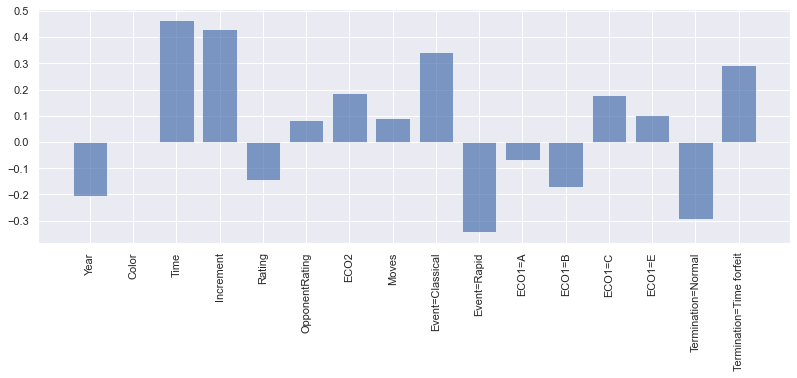

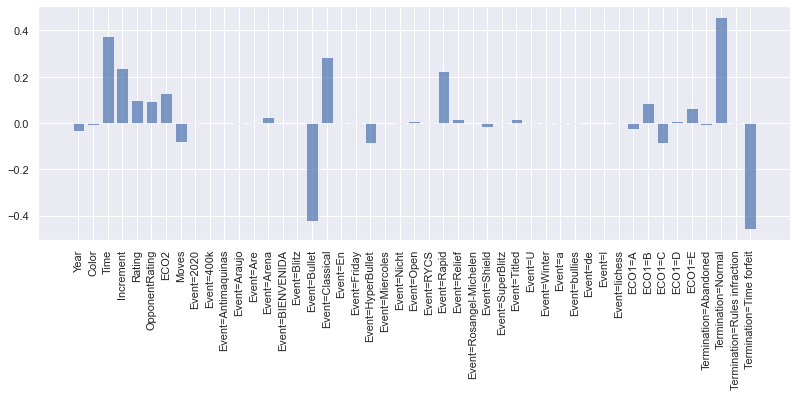

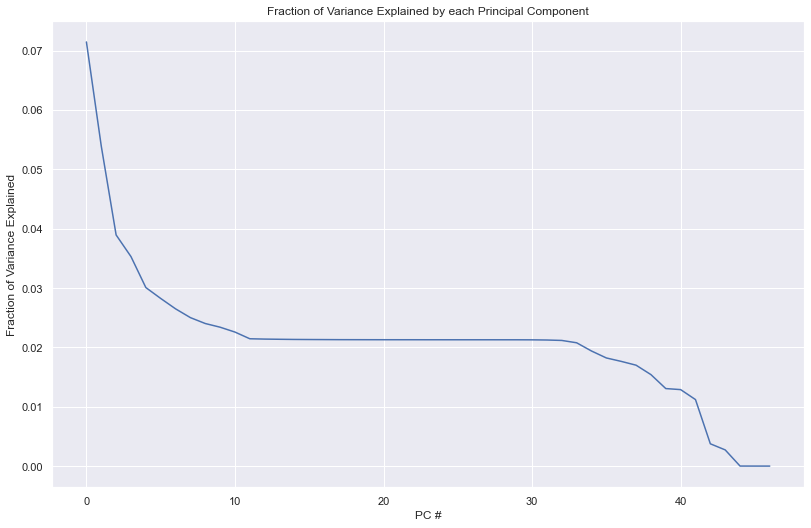

In [61]:
def ohe(df, colname):
    vec = DictVectorizer()
    vec.fit(df[[colname]].to_dict(orient='records'))
    col_data = vec.transform(df[[colname]].to_dict(orient='records')).toarray()
    col_unique = vec.get_feature_names()
    col_ohe = pd.DataFrame(col_data, columns=col_unique)
    df = pd.concat([df, col_ohe], axis=1)
    #df = df.drop(columns=col_unique[0])
    return df

def unique_names(df, colname):
    vec = DictVectorizer()
    vec.fit(df[[colname]].to_dict(orient='records'))
    col_data = vec.transform(df[[colname]].to_dict(orient='records')).toarray()
    col_unique = vec.get_feature_names()
    return col_unique


def df_transformation(df, cols):
    data = df[cols]
    
    data = data.replace("Black", 0).replace("White", 1)
    data = ohe(data, "Event").drop("Event", axis=1)
    data = ohe(data, "ECO1").drop("ECO1", axis=1)
    data = ohe(data, "Termination").drop("Termination", axis=1)
    
    pca(data, cols)
    
    data["Result"] = df["Result"]
    return data


def pca(df, cols):
    
    # Center data
    df_mean = df.mean(axis=0)
    df_centered = df - df_mean
    
    
    # Scale - each col has unit variance
    df_centered_scaled = df_centered / np.sqrt(np.var(df_centered))

    # for the case where all values are 0, SVD doesn't converge
    df_centered_scaled = df_centered_scaled.fillna(0)
    
    # Break into components
    #df_centered_scaled.dropna(inplace=True)
    u, s, vt = np.linalg.svd(df_centered_scaled, full_matrices=False)

    v = vt.T
    P = df_centered @ v
    
    plt.figure(figsize=(12, 4))
    plt.bar(df.columns, vt[0, :], alpha=0.7)
    plt.xticks(df.columns, rotation=90)
    plt.show()
    
    
    # Scree plot
    plt.plot(s**2 / sum(s**2));
    #plt.xticks([1, 2, 3], [1, 2, 3]);
    plt.xlabel('PC #');
    plt.ylabel('Fraction of Variance Explained');
    plt.title('Fraction of Variance Explained by each Principal Component')
    
    return P

print("USER DATA FIRST, MODEL_DF SECOND ")
print()
log_df = df_transformation(df, ["Year", "Color", "Time", "Increment", "Event", "Rating", "OpponentRating", "ECO1", "ECO2", "Moves", "Termination"])


model_df_load = pd.read_csv("model_df.csv")
model_df = df_transformation(model_df_load, ["Year", "Color", "Time", "Increment", "Event", "Rating", "OpponentRating", "ECO1", "ECO2", "Moves", "Termination"])

In [62]:
def rmse(actual, predicted):
    return np.sqrt(np.sum((actual - predicted)**2) / len(actual))


def model(data, prnt, option, df="", events="", eco1="", self=False):
    
    data["Result_numeric"] = data["Result"]
    di = {0.0: "Loss", 0.5: "Draw", 1.0: "Win"}
    data = data.replace({"Result":di})
    
    test_size = 0.2
    train, test = train_test_split(data, test_size=test_size, 
                                  #random_state=40
                                 )

    # Logistic Regression
    X_train_log = process_data(train, option, events, eco1, self)
    y_train_log = train["Result"]
    
    model = LogisticRegression(multi_class='multinomial',solver ='newton-cg', max_iter = len(X_train_log))
    model.fit(X_train_log, y_train_log)
    
    
    training_score_log = model.score(X_train_log, y_train_log)
    
    X_test_log = process_data(test, option, events, eco1, self)
    y_test_log = test["Result"]
    
    test_score_log = model.score(X_test_log, y_test_log)
    
    
    #df["Result_numeric"] = df["Result"]
    #X_self_log = process_data(df, option, events)
    #y_self_log = df["Result"]
    #self_score_log = model.score(X_self_log, y_self_log)
    
    
    
    # Linear Regression
    X_train_lin = X_train_log
    y_train_lin = train["Result_numeric"]
    X_test_lin = X_test_log
    y_test_lin = test["Result_numeric"]
    
    model_ln = lm.LinearRegression(fit_intercept=True)
    model_ln.fit(X_train_lin, y_train_lin)
    y_predicted_train_lin = model_ln.predict(X_train_lin)
    y_predicted_test_lin = model_ln.predict(X_test_lin)
    
    
    training_rmse = rmse(y_predicted_train_lin, y_train_lin)
    
    test_rmse = rmse(y_predicted_test_lin, y_test_lin)
    
    if (prnt == True):
        print("Training set size: " + str(len(train)))
        print("Test set size: " + str(len(test)))
        print()
        print("Logistic")
        print("Training accuracy: " + str(training_score_log))
        print("Test accuracy: " + str(test_score_log))
        #if (df != ""):
            #print("Self accuracy: " + str(self_score_log))
        print()
        #print("Linear")
        #print("Training RMSE: " + str(training_rmse))
        #print("Test RMSE: " + str(test_rmse))
    
    #return model_ln.predict([[1,30,0,1387,1862,0,1,0,0,0]])
    #return y_predicted_train_lin
    return model, model_ln

def process_data(data, option, events, eco1, self):
    
    
    # Drops
    filter_eco = [col for col in data if col.startswith("ECO1")]
    if (option < 1):
        for i in filter_eco:
            data = data.drop(i, axis=1)
    elif (self == False):
        for i in filter_eco:
            if i not in eco1:
                data = data.drop(i, axis=1)
    data = data.drop("ECO2", axis=1)
            
        
    filter_ter = [col for col in data if col.startswith("Termination")]
    for i in filter_ter:
        data = data.drop(i, axis=1)
        
    
    # Events
    if (self == False):
        filter_eve = [col for col in data if col.startswith("Event=")]
        for i in filter_eve:
            if i not in events:
                data = data.drop(i, axis=1)
    
        
    data = data.drop(["Moves", "Year", "Result", "Result_numeric"], axis=1)
    
    if (self == False):
        data = data.drop(["Time", "Increment"], axis=1)
    else:
        data = data.drop(["Rating"], axis=1)

    return data


    

<br>

### 9.1&emsp;Model 1 : Predictor using model_df

<br>

This model uses model_df as training dataset for the model. model_df contains over 49,000 games, with at least 5000 in each of the four game modes. It also spans a rating range of around 1000 to 3000, which I tried to balance evenly for each of the four modes.

**Inputs**: The user enters the side a user plays on, the user's rating, the opponent's rating and the game type. 

<br>

In [63]:
"""
color: enter "White" or "Black"
rating, opponentRating
event: enter "Blitz", "Bullet", "Classical", "Rapid", or anything else that showed up in "Event" for the PGN file.
"""

side = "Black"
rating = 1980
opponentrating = 1960
event = "Rapid"



standard = []
uni = unique_names(df, "Event")
allowed_uni = ["Event=Bullet", "Event=Blitz", "Event=Rapid", "Event=Classical"]
for i in uni:
    if i in allowed_uni:
        standard.append(i)
event_list = [int(("Event=" + event) == i) for i in standard]


model_1, model_2 = model(model_df, True, 0, df, standard)

if (side == "White"):
    side = 1
else:
    side = 0


concat_list = [side,  rating, opponentrating] + event_list


print(color.YELLOW + "PREDICTED RESULT: " + color.PURPLE + model_1.predict([concat_list])[0])
print(color.YELLOW + "PREDICTED PPG:    " + color.PURPLE + str(round(model_2.predict([concat_list])[0], 4)) + color.END)

Training set size: 39264
Test set size: 9816

Logistic
Training accuracy: 0.6336083944580277
Test accuracy: 0.6271393643031785

PREDICTED RESULT: Win
PREDICTED PPG:    0.5211


<br>

### 9.2&emsp;Model 2 : Predictor without game knowledge

<br>

This model uses the user's own games to make a prediction.

**Inputs**: The user enters the side a user plays on, the time control, the opponent's rating and the game type. 

<br>

In [64]:
"""
color: enter "White" or "Black"
time, increment = time control, ex. 10+5 (set to 10 and 5, for 10 minutes and 5 second increment)
opponentRating
event: enter "Blitz", "Bullet", "Classical", "Rapid", or anything else that showed up in "Event" for the PGN file.
"""

side = "White"
time = 5
increment = 3
opponentrating = 1300

event = "Blitz"



model_1, model_2 = model(log_df, True, 0, self=True)

if (side == "White"):
    side = 1
else:
    side = 0

time = time * 60
    
uni = unique_names(df, "Event")
event_list = [int(("Event=" + event) == i) for i in uni]

concat_list = [side, time, increment, opponentrating] + event_list


print(color.YELLOW + "PREDICTED RESULT: " + color.PURPLE + model_1.predict([concat_list])[0])
print(color.YELLOW + "PREDICTED PPG:    " + color.PURPLE + str(round(model_2.predict([concat_list])[0], 4)) + color.END)

Training set size: 40
Test set size: 11

Logistic
Training accuracy: 0.675
Test accuracy: 0.36363636363636365

PREDICTED RESULT: Win
PREDICTED PPG:    0.6347


<br>

### 9.3&emsp;Model 3 : Predictor with opening knowledge

<br>

This model uses the user's own games to make a prediction.

**Inputs**: The user enters the side a user plays on, the time control, the opponent's rating, the game type, and also the ECO letter code.

<br>

In [65]:
"""
color: enter "White" or "Black"
time, increment = time control, ex. 10+5 (set to 10 and 5, for 10 minutes and 5 second increment)
opponentRating
eco1 = letter of ECO opening (ex. "C" from C45)
event: enter "Blitz", "Bullet", "Classical", "Rapid", or anything else that showed up in "Event" for the PGN file.
"""

side = "White"
time = 1
increment = 0
opponentrating = 1100
eco1 = "C"
event = "Bullet"



model_1, model_2 = model(log_df, True, 1, self=True)

if (side == "White"):
    side = 1
else:
    side = 0

time = time * 60
    
uni = unique_names(df, "Event")
event_list = [int(("Event=" + event) == i) for i in uni]

eco = unique_names(df, "ECO1")
eco_list = [int(("ECO1=" + eco1) == i) for i in eco]

concat_list = [side, time, increment, opponentrating] + event_list + eco_list


print(color.YELLOW + "PREDICTED RESULT: " + color.PURPLE + model_1.predict([concat_list])[0])
print(color.YELLOW + "PREDICTED PPG:    " + color.PURPLE + str(round(model_2.predict([concat_list])[0], 4)) + color.END)

Training set size: 40
Test set size: 11

Logistic
Training accuracy: 0.625
Test accuracy: 0.6363636363636364

PREDICTED RESULT: Draw
PREDICTED PPG:    0.8102
